In [1]:
import numpy as np
import imageio
import os
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
import gymnasium  as gym
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
import scipy.stats as stats
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv 

<h1> Important Libraries To Install </h1>

In [2]:
!pip install gym
!pip install pyglet==1.5.27
!pip install stable-baseline3
!pip install "gymnasium[all]"


ERROR: Could not find a version that satisfies the requirement stable-baseline3 (from versions: none)
ERROR: No matching distribution found for stable-baseline3


<h1> Parameter & Environment Information </h1>

<p>
    This environment is part of the Box2D environments.
</p>

<ul>
    <li> Action Space Discrete(4) </li>
    <li> Observation Shape (8,) </li>
    <li> Observation High [1.5 1.5 5. 5. 3.14 5. 1. 1. ] </li>
    <li> Observation Low [-1.5 -1.5 -5. -5. -3.14 -5. -0. -0. ] </li>
    <li> Import gymnasium.make("LunarLander-v2") </li>
</ul>

<h3> Description </h3>
<p>This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.</p>

<h3> Action Space </h3>
<p>
There are four discrete actions available:

* 0: do nothing
* 1: fire left orientation engine
* 2: fire main engine
* 3: fire right orientation engine

</p>

<h3> Observation Space </h3>
<p>
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.
</p>

<h3> Reward </h3>
<p>
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

* is increased/decreased the closer/further the lander is to the landing pad.
* is increased/decreased the slower/faster the lander is moving.
* is decreased the more the lander is tilted (angle not horizontal).
* is increased by 10 points for each leg that is in contact with the ground.
* is decreased by 0.03 points each frame a side engine is firing.
* is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.
</p>

<h3> Starting State </h3>

<p>The lander starts at the top center of the viewport with a random initial force applied to its center of mass.</p>

<h3> Episode Termination </h3>
<p> The episode finishes if:<br>
    
1. the lander crashes (the lander body gets in contact with the moon);<br>
2. the lander gets outside of the viewport (x coordinate is greater than 1);<br>
3. the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:<br>

When Box2D determines that a body (or group of bodies) has come to rest, the body enters a sleep state which has very little CPU overhead. If a body is awake and collides with a sleeping body, then the sleeping body wakes up. Bodies will also wake up if a joint or contact attached to them is destroyed.
</p>

In [2]:
env = gym.make("LunarLander-v2", render_mode="human")

In [3]:
print("The Action inter is descrete {}".format(env.action_space.n))
print("Shape of Observation is {}".format(env.observation_space.sample().shape))

The Action inter is descrete 4
Shape of Observation is (8,)


<h1> Baseline Model. </h1>

In [4]:
rewards = []
obs = env.reset()
done = False
MAX_RUN = 10

for i in range(MAX_RUN):
    while not done:
        env.render()
        action_sample = env.action_space.sample()
        # let's take a step in the environment 
        obs, rwd, done, info ,_  = env.step(action_sample)
        rewards.append(rwd)
env.close()
print("Mean Reward after {} max run is {}".format(MAX_RUN, np.mean(np.array(rewards))))

Mean Reward after 10 max run is -1.2346880943500231


<h1> Reinforcement Learning For Training The Model </h1>

In [5]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [6]:
env = make_vec_env("LunarLander-v2", n_envs=1,monitor_dir="log_dir_A2C_8/")

policy = "MlpPolicy"
n_steps = 100
learning_rate = 0.0003
batch_size = 256
n_epochs = 10

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir="log_dir_A2C_8/")
# instantiate the agent 
model = A2C(policy, env, learning_rate = learning_rate, n_steps = n_steps,tensorboard_log="./TensorBoardLog/", verbose=1)
# train the agent
model.learn(total_timesteps=8000000, callback=callback)

Using cpu device
Logging to ./TensorBoardLog/A2C_7
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -205.89
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 2000
Best mean reward: -205.89 - Last mean reward per episode: -199.48
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 3000
Best mean reward: -199.48 - Last mean reward per episode: -194.56
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 4000
Best mean reward: -194.56 - Last mean reward per episode: -182.98
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 5000
Best mean reward: -182.98 - Last mean reward per episode: -181.72
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 6000
Best mean reward: -181.72 - Last mean reward per episode: -172.56
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 7000
Best mean reward: -172.56 - Last mean reward per episode: -173.52
Num timesteps: 8000
Best m

Num timesteps: 51000
Best mean reward: -146.06 - Last mean reward per episode: -146.16
Num timesteps: 52000
Best mean reward: -146.06 - Last mean reward per episode: -143.67
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 53000
Best mean reward: -143.67 - Last mean reward per episode: -145.25
Num timesteps: 54000
Best mean reward: -143.67 - Last mean reward per episode: -144.89
Num timesteps: 55000
Best mean reward: -143.67 - Last mean reward per episode: -144.89
Num timesteps: 56000
Best mean reward: -143.67 - Last mean reward per episode: -138.36
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 57000
Best mean reward: -138.36 - Last mean reward per episode: -136.44
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 58000
Best mean reward: -136.44 - Last mean reward per episode: -138.49
Num timesteps: 59000
Best mean reward: -136.44 - Last mean reward per episode: -141.03
Num timesteps: 60000
Best mean reward: -136.44 - Last m

Num timesteps: 106000
Best mean reward: -124.02 - Last mean reward per episode: -124.21
Num timesteps: 107000
Best mean reward: -124.02 - Last mean reward per episode: -124.12
Num timesteps: 108000
Best mean reward: -124.02 - Last mean reward per episode: -125.00
Num timesteps: 109000
Best mean reward: -124.02 - Last mean reward per episode: -127.07
Num timesteps: 110000
Best mean reward: -124.02 - Last mean reward per episode: -123.95
Saving new best model to log_dir_A2C_8/best_model.zip
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 125       |
|    ep_rew_mean        | -124      |
| time/                 |           |
|    fps                | 2528      |
|    iterations         | 1100      |
|    time_elapsed       | 43        |
|    total_timesteps    | 110000    |
| train/                |           |
|    entropy_loss       | -1.2      |
|    explained_variance | -6.06e-05 |
|    learning_rate      | 0.0003    |
|    n_updat

Num timesteps: 157000
Best mean reward: -99.55 - Last mean reward per episode: -98.41
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 158000
Best mean reward: -98.41 - Last mean reward per episode: -98.84
Num timesteps: 159000
Best mean reward: -98.41 - Last mean reward per episode: -98.17
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 160000
Best mean reward: -98.17 - Last mean reward per episode: -96.81
Saving new best model to log_dir_A2C_8/best_model.zip
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 155       |
|    ep_rew_mean        | -96.8     |
| time/                 |           |
|    fps                | 2429      |
|    iterations         | 1600      |
|    time_elapsed       | 65        |
|    total_timesteps    | 160000    |
| train/                |           |
|    entropy_loss       | -1.11     |
|    explained_variance | -9.95e-05 |
|    learning_rate      | 0.0003    |


Num timesteps: 201000
Best mean reward: -40.93 - Last mean reward per episode: -44.30
Num timesteps: 202000
Best mean reward: -40.93 - Last mean reward per episode: -39.86
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 203000
Best mean reward: -39.86 - Last mean reward per episode: -38.20
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 204000
Best mean reward: -38.20 - Last mean reward per episode: -36.02
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 205000
Best mean reward: -36.02 - Last mean reward per episode: -39.00
Num timesteps: 206000
Best mean reward: -36.02 - Last mean reward per episode: -36.99
Num timesteps: 207000
Best mean reward: -36.02 - Last mean reward per episode: -37.76
Num timesteps: 208000
Best mean reward: -36.02 - Last mean reward per episode: -40.13
Num timesteps: 209000
Best mean reward: -36.02 - Last mean reward per episode: -40.03
Num timesteps: 210000
Best mean reward: -36.02 - Last mean rewar

Num timesteps: 251000
Best mean reward: -19.93 - Last mean reward per episode: -20.08
Num timesteps: 252000
Best mean reward: -19.93 - Last mean reward per episode: -19.45
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 253000
Best mean reward: -19.45 - Last mean reward per episode: -18.74
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 254000
Best mean reward: -18.74 - Last mean reward per episode: -17.80
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 255000
Best mean reward: -17.80 - Last mean reward per episode: -16.80
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 256000
Best mean reward: -16.80 - Last mean reward per episode: -15.42
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 257000
Best mean reward: -15.42 - Last mean reward per episode: -15.66
Num timesteps: 258000
Best mean reward: -15.42 - Last mean reward per episode: -14.52
Saving new best model to log_dir_A2C_8/bes

Num timesteps: 304000
Best mean reward: -11.42 - Last mean reward per episode: -17.96
Num timesteps: 305000
Best mean reward: -11.42 - Last mean reward per episode: -15.65
Num timesteps: 306000
Best mean reward: -11.42 - Last mean reward per episode: -15.81
Num timesteps: 307000
Best mean reward: -11.42 - Last mean reward per episode: -15.96
Num timesteps: 308000
Best mean reward: -11.42 - Last mean reward per episode: -14.00
Num timesteps: 309000
Best mean reward: -11.42 - Last mean reward per episode: -14.16
Num timesteps: 310000
Best mean reward: -11.42 - Last mean reward per episode: -15.11
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 392      |
|    ep_rew_mean        | -15.1    |
| time/                 |          |
|    fps                | 1794     |
|    iterations         | 3100     |
|    time_elapsed       | 172      |
|    total_timesteps    | 310000   |
| train/                |          |
|    entropy_loss       | -1

Num timesteps: 357000
Best mean reward: 2.42 - Last mean reward per episode: -0.01
Num timesteps: 358000
Best mean reward: 2.42 - Last mean reward per episode: 0.35
Num timesteps: 359000
Best mean reward: 2.42 - Last mean reward per episode: 1.11
Num timesteps: 360000
Best mean reward: 2.42 - Last mean reward per episode: -2.94
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 597      |
|    ep_rew_mean        | -2.94    |
| time/                 |          |
|    fps                | 1530     |
|    iterations         | 3600     |
|    time_elapsed       | 235      |
|    total_timesteps    | 360000   |
| train/                |          |
|    entropy_loss       | -1.1     |
|    explained_variance | 0.0208   |
|    learning_rate      | 0.0003   |
|    n_updates          | 3599     |
|    policy_loss        | -4.94    |
|    value_loss         | 138      |
------------------------------------
Num timesteps: 361000
Best mean reward: 2

Num timesteps: 411000
Best mean reward: 16.45 - Last mean reward per episode: 14.12
Num timesteps: 412000
Best mean reward: 16.45 - Last mean reward per episode: 14.86
Num timesteps: 413000
Best mean reward: 16.45 - Last mean reward per episode: 13.47
Num timesteps: 414000
Best mean reward: 16.45 - Last mean reward per episode: 15.52
Num timesteps: 415000
Best mean reward: 16.45 - Last mean reward per episode: 16.38
Num timesteps: 416000
Best mean reward: 16.45 - Last mean reward per episode: 15.82
Num timesteps: 417000
Best mean reward: 16.45 - Last mean reward per episode: 15.74
Num timesteps: 418000
Best mean reward: 16.45 - Last mean reward per episode: 18.61
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 419000
Best mean reward: 18.61 - Last mean reward per episode: 21.15
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 420000
Best mean reward: 21.15 - Last mean reward per episode: 23.42
Saving new best model to log_dir_A2C_8/best_model.zi

Num timesteps: 461000
Best mean reward: 62.80 - Last mean reward per episode: 69.28
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 462000
Best mean reward: 69.28 - Last mean reward per episode: 71.41
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 463000
Best mean reward: 71.41 - Last mean reward per episode: 72.51
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 464000
Best mean reward: 72.51 - Last mean reward per episode: 76.33
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 465000
Best mean reward: 76.33 - Last mean reward per episode: 77.02
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 466000
Best mean reward: 77.02 - Last mean reward per episode: 80.32
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 467000
Best mean reward: 80.32 - Last mean reward per episode: 81.35
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 468000
Best mean re

Num timesteps: 515000
Best mean reward: 89.16 - Last mean reward per episode: 84.50
Num timesteps: 516000
Best mean reward: 89.16 - Last mean reward per episode: 83.35
Num timesteps: 517000
Best mean reward: 89.16 - Last mean reward per episode: 80.80
Num timesteps: 518000
Best mean reward: 89.16 - Last mean reward per episode: 80.41
Num timesteps: 519000
Best mean reward: 89.16 - Last mean reward per episode: 82.76
Num timesteps: 520000
Best mean reward: 89.16 - Last mean reward per episode: 82.98
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 727      |
|    ep_rew_mean        | 83       |
| time/                 |          |
|    fps                | 1137     |
|    iterations         | 5200     |
|    time_elapsed       | 457      |
|    total_timesteps    | 520000   |
| train/                |          |
|    entropy_loss       | -1.12    |
|    explained_variance | -0.189   |
|    learning_rate      | 0.0003   |
|    n_updates 

Num timesteps: 571000
Best mean reward: 94.90 - Last mean reward per episode: 93.59
Num timesteps: 572000
Best mean reward: 94.90 - Last mean reward per episode: 91.93
Num timesteps: 573000
Best mean reward: 94.90 - Last mean reward per episode: 91.67
Num timesteps: 574000
Best mean reward: 94.90 - Last mean reward per episode: 93.96
Num timesteps: 575000
Best mean reward: 94.90 - Last mean reward per episode: 94.92
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 576000
Best mean reward: 94.92 - Last mean reward per episode: 92.16
Num timesteps: 577000
Best mean reward: 94.92 - Last mean reward per episode: 93.97
Num timesteps: 578000
Best mean reward: 94.92 - Last mean reward per episode: 96.31
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 579000
Best mean reward: 96.31 - Last mean reward per episode: 96.19
Num timesteps: 580000
Best mean reward: 96.31 - Last mean reward per episode: 97.95
Saving new best model to log_dir_A2C_8/best_model.zi

Num timesteps: 621000
Best mean reward: 123.14 - Last mean reward per episode: 120.72
Num timesteps: 622000
Best mean reward: 123.14 - Last mean reward per episode: 122.27
Num timesteps: 623000
Best mean reward: 123.14 - Last mean reward per episode: 119.66
Num timesteps: 624000
Best mean reward: 123.14 - Last mean reward per episode: 118.38
Num timesteps: 625000
Best mean reward: 123.14 - Last mean reward per episode: 118.82
Num timesteps: 626000
Best mean reward: 123.14 - Last mean reward per episode: 116.44
Num timesteps: 627000
Best mean reward: 123.14 - Last mean reward per episode: 119.09
Num timesteps: 628000
Best mean reward: 123.14 - Last mean reward per episode: 117.32
Num timesteps: 629000
Best mean reward: 123.14 - Last mean reward per episode: 119.70
Num timesteps: 630000
Best mean reward: 123.14 - Last mean reward per episode: 120.36
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 568      |
|    ep_rew_mean        | 120

Num timesteps: 674000
Best mean reward: 142.99 - Last mean reward per episode: 130.52
Num timesteps: 675000
Best mean reward: 142.99 - Last mean reward per episode: 131.90
Num timesteps: 676000
Best mean reward: 142.99 - Last mean reward per episode: 131.75
Num timesteps: 677000
Best mean reward: 142.99 - Last mean reward per episode: 130.84
Num timesteps: 678000
Best mean reward: 142.99 - Last mean reward per episode: 133.08
Num timesteps: 679000
Best mean reward: 142.99 - Last mean reward per episode: 135.18
Num timesteps: 680000
Best mean reward: 142.99 - Last mean reward per episode: 136.00
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 484      |
|    ep_rew_mean        | 136      |
| time/                 |          |
|    fps                | 1036     |
|    iterations         | 6800     |
|    time_elapsed       | 655      |
|    total_timesteps    | 680000   |
| train/                |          |
|    entropy_loss       | -1

Num timesteps: 731000
Best mean reward: 142.99 - Last mean reward per episode: 113.05
Num timesteps: 732000
Best mean reward: 142.99 - Last mean reward per episode: 113.57
Num timesteps: 733000
Best mean reward: 142.99 - Last mean reward per episode: 111.18
Num timesteps: 734000
Best mean reward: 142.99 - Last mean reward per episode: 111.44
Num timesteps: 735000
Best mean reward: 142.99 - Last mean reward per episode: 111.18
Num timesteps: 736000
Best mean reward: 142.99 - Last mean reward per episode: 106.96
Num timesteps: 737000
Best mean reward: 142.99 - Last mean reward per episode: 103.43
Num timesteps: 738000
Best mean reward: 142.99 - Last mean reward per episode: 106.77
Num timesteps: 739000
Best mean reward: 142.99 - Last mean reward per episode: 103.28
Num timesteps: 740000
Best mean reward: 142.99 - Last mean reward per episode: 98.56
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 410      |
|    ep_rew_mean        | 98.6

Num timesteps: 791000
Best mean reward: 142.99 - Last mean reward per episode: 130.00
Num timesteps: 792000
Best mean reward: 142.99 - Last mean reward per episode: 130.24
Num timesteps: 793000
Best mean reward: 142.99 - Last mean reward per episode: 129.37
Num timesteps: 794000
Best mean reward: 142.99 - Last mean reward per episode: 135.45
Num timesteps: 795000
Best mean reward: 142.99 - Last mean reward per episode: 135.67
Num timesteps: 796000
Best mean reward: 142.99 - Last mean reward per episode: 131.80
Num timesteps: 797000
Best mean reward: 142.99 - Last mean reward per episode: 136.98
Num timesteps: 798000
Best mean reward: 142.99 - Last mean reward per episode: 138.75
Num timesteps: 799000
Best mean reward: 142.99 - Last mean reward per episode: 141.94
Num timesteps: 800000
Best mean reward: 142.99 - Last mean reward per episode: 142.10
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 366      |
|    ep_rew_mean        | 142

Num timesteps: 849000
Best mean reward: 151.91 - Last mean reward per episode: 92.84
Num timesteps: 850000
Best mean reward: 151.91 - Last mean reward per episode: 93.05
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 327      |
|    ep_rew_mean        | 93.1     |
| time/                 |          |
|    fps                | 1073     |
|    iterations         | 8500     |
|    time_elapsed       | 792      |
|    total_timesteps    | 850000   |
| train/                |          |
|    entropy_loss       | -0.906   |
|    explained_variance | 0.238    |
|    learning_rate      | 0.0003   |
|    n_updates          | 8499     |
|    policy_loss        | 13       |
|    value_loss         | 453      |
------------------------------------
Num timesteps: 851000
Best mean reward: 151.91 - Last mean reward per episode: 94.96
Num timesteps: 852000
Best mean reward: 151.91 - Last mean reward per episode: 91.98
Num timesteps: 853000
Best mean

Num timesteps: 901000
Best mean reward: 151.91 - Last mean reward per episode: 96.87
Num timesteps: 902000
Best mean reward: 151.91 - Last mean reward per episode: 95.12
Num timesteps: 903000
Best mean reward: 151.91 - Last mean reward per episode: 97.36
Num timesteps: 904000
Best mean reward: 151.91 - Last mean reward per episode: 100.88
Num timesteps: 905000
Best mean reward: 151.91 - Last mean reward per episode: 98.08
Num timesteps: 906000
Best mean reward: 151.91 - Last mean reward per episode: 99.98
Num timesteps: 907000
Best mean reward: 151.91 - Last mean reward per episode: 102.03
Num timesteps: 908000
Best mean reward: 151.91 - Last mean reward per episode: 104.46
Num timesteps: 909000
Best mean reward: 151.91 - Last mean reward per episode: 106.07
Num timesteps: 910000
Best mean reward: 151.91 - Last mean reward per episode: 103.06
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 287      |
|    ep_rew_mean        | 103     

Num timesteps: 961000
Best mean reward: 151.91 - Last mean reward per episode: 86.55
Num timesteps: 962000
Best mean reward: 151.91 - Last mean reward per episode: 84.39
Num timesteps: 963000
Best mean reward: 151.91 - Last mean reward per episode: 85.08
Num timesteps: 964000
Best mean reward: 151.91 - Last mean reward per episode: 91.46
Num timesteps: 965000
Best mean reward: 151.91 - Last mean reward per episode: 94.06
Num timesteps: 966000
Best mean reward: 151.91 - Last mean reward per episode: 91.60
Num timesteps: 967000
Best mean reward: 151.91 - Last mean reward per episode: 96.23
Num timesteps: 968000
Best mean reward: 151.91 - Last mean reward per episode: 94.20
Num timesteps: 969000
Best mean reward: 151.91 - Last mean reward per episode: 97.37
Num timesteps: 970000
Best mean reward: 151.91 - Last mean reward per episode: 95.07
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 271      |
|    ep_rew_mean        | 95.1     |
| 

Num timesteps: 1020000
Best mean reward: 151.91 - Last mean reward per episode: 84.89
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 242      |
|    ep_rew_mean        | 84.9     |
| time/                 |          |
|    fps                | 1141     |
|    iterations         | 10200    |
|    time_elapsed       | 893      |
|    total_timesteps    | 1020000  |
| train/                |          |
|    entropy_loss       | -1.02    |
|    explained_variance | 0.18     |
|    learning_rate      | 0.0003   |
|    n_updates          | 10199    |
|    policy_loss        | -17.4    |
|    value_loss         | 350      |
------------------------------------
Num timesteps: 1021000
Best mean reward: 151.91 - Last mean reward per episode: 83.80
Num timesteps: 1022000
Best mean reward: 151.91 - Last mean reward per episode: 83.08
Num timesteps: 1023000
Best mean reward: 151.91 - Last mean reward per episode: 77.80
Num timesteps: 1024000
Best

Num timesteps: 1072000
Best mean reward: 151.91 - Last mean reward per episode: 53.83
Num timesteps: 1073000
Best mean reward: 151.91 - Last mean reward per episode: 50.14
Num timesteps: 1074000
Best mean reward: 151.91 - Last mean reward per episode: 50.53
Num timesteps: 1075000
Best mean reward: 151.91 - Last mean reward per episode: 46.13
Num timesteps: 1076000
Best mean reward: 151.91 - Last mean reward per episode: 46.38
Num timesteps: 1077000
Best mean reward: 151.91 - Last mean reward per episode: 52.88
Num timesteps: 1078000
Best mean reward: 151.91 - Last mean reward per episode: 51.68
Num timesteps: 1079000
Best mean reward: 151.91 - Last mean reward per episode: 58.07
Num timesteps: 1080000
Best mean reward: 151.91 - Last mean reward per episode: 58.22
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 245      |
|    ep_rew_mean        | 58.2     |
| time/                 |          |
|    fps                | 1168     |
|   

Num timesteps: 1131000
Best mean reward: 151.91 - Last mean reward per episode: 107.28
Num timesteps: 1132000
Best mean reward: 151.91 - Last mean reward per episode: 103.39
Num timesteps: 1133000
Best mean reward: 151.91 - Last mean reward per episode: 108.10
Num timesteps: 1134000
Best mean reward: 151.91 - Last mean reward per episode: 109.65
Num timesteps: 1135000
Best mean reward: 151.91 - Last mean reward per episode: 108.89
Num timesteps: 1136000
Best mean reward: 151.91 - Last mean reward per episode: 110.23
Num timesteps: 1137000
Best mean reward: 151.91 - Last mean reward per episode: 112.22
Num timesteps: 1138000
Best mean reward: 151.91 - Last mean reward per episode: 112.26
Num timesteps: 1139000
Best mean reward: 151.91 - Last mean reward per episode: 115.68
Num timesteps: 1140000
Best mean reward: 151.91 - Last mean reward per episode: 115.48
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 310      |
|    ep_rew_mean   

Num timesteps: 1190000
Best mean reward: 151.91 - Last mean reward per episode: 100.28
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 365      |
|    ep_rew_mean        | 100      |
| time/                 |          |
|    fps                | 1187     |
|    iterations         | 11900    |
|    time_elapsed       | 1002     |
|    total_timesteps    | 1190000  |
| train/                |          |
|    entropy_loss       | -0.979   |
|    explained_variance | 0.869    |
|    learning_rate      | 0.0003   |
|    n_updates          | 11899    |
|    policy_loss        | 1.01     |
|    value_loss         | 9.9      |
------------------------------------
Num timesteps: 1191000
Best mean reward: 151.91 - Last mean reward per episode: 99.70
Num timesteps: 1192000
Best mean reward: 151.91 - Last mean reward per episode: 102.68
Num timesteps: 1193000
Best mean reward: 151.91 - Last mean reward per episode: 102.53
Num timesteps: 1194000
B

Num timesteps: 1242000
Best mean reward: 151.91 - Last mean reward per episode: 101.77
Num timesteps: 1243000
Best mean reward: 151.91 - Last mean reward per episode: 98.69
Num timesteps: 1244000
Best mean reward: 151.91 - Last mean reward per episode: 98.47
Num timesteps: 1245000
Best mean reward: 151.91 - Last mean reward per episode: 99.49
Num timesteps: 1246000
Best mean reward: 151.91 - Last mean reward per episode: 101.61
Num timesteps: 1247000
Best mean reward: 151.91 - Last mean reward per episode: 101.22
Num timesteps: 1248000
Best mean reward: 151.91 - Last mean reward per episode: 103.53
Num timesteps: 1249000
Best mean reward: 151.91 - Last mean reward per episode: 103.90
Num timesteps: 1250000
Best mean reward: 151.91 - Last mean reward per episode: 101.15
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 465      |
|    ep_rew_mean        | 101      |
| time/                 |          |
|    fps                | 1184     

Num timesteps: 1301000
Best mean reward: 151.91 - Last mean reward per episode: 90.71
Num timesteps: 1302000
Best mean reward: 151.91 - Last mean reward per episode: 92.88
Num timesteps: 1303000
Best mean reward: 151.91 - Last mean reward per episode: 91.45
Num timesteps: 1304000
Best mean reward: 151.91 - Last mean reward per episode: 93.84
Num timesteps: 1305000
Best mean reward: 151.91 - Last mean reward per episode: 93.63
Num timesteps: 1306000
Best mean reward: 151.91 - Last mean reward per episode: 89.59
Num timesteps: 1307000
Best mean reward: 151.91 - Last mean reward per episode: 92.59
Num timesteps: 1308000
Best mean reward: 151.91 - Last mean reward per episode: 98.71
Num timesteps: 1309000
Best mean reward: 151.91 - Last mean reward per episode: 103.21
Num timesteps: 1310000
Best mean reward: 151.91 - Last mean reward per episode: 100.90
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 476      |
|    ep_rew_mean        | 1

Num timesteps: 1360000
Best mean reward: 151.91 - Last mean reward per episode: 133.36
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 439      |
|    ep_rew_mean        | 133      |
| time/                 |          |
|    fps                | 1172     |
|    iterations         | 13600    |
|    time_elapsed       | 1159     |
|    total_timesteps    | 1360000  |
| train/                |          |
|    entropy_loss       | -0.981   |
|    explained_variance | 0.611    |
|    learning_rate      | 0.0003   |
|    n_updates          | 13599    |
|    policy_loss        | -2.85    |
|    value_loss         | 13.4     |
------------------------------------
Num timesteps: 1361000
Best mean reward: 151.91 - Last mean reward per episode: 133.40
Num timesteps: 1362000
Best mean reward: 151.91 - Last mean reward per episode: 133.07
Num timesteps: 1363000
Best mean reward: 151.91 - Last mean reward per episode: 134.79
Num timesteps: 1364000


Num timesteps: 1411000
Best mean reward: 151.91 - Last mean reward per episode: 130.13
Num timesteps: 1412000
Best mean reward: 151.91 - Last mean reward per episode: 122.79
Num timesteps: 1413000
Best mean reward: 151.91 - Last mean reward per episode: 119.43
Num timesteps: 1414000
Best mean reward: 151.91 - Last mean reward per episode: 119.15
Num timesteps: 1415000
Best mean reward: 151.91 - Last mean reward per episode: 119.05
Num timesteps: 1416000
Best mean reward: 151.91 - Last mean reward per episode: 117.67
Num timesteps: 1417000
Best mean reward: 151.91 - Last mean reward per episode: 112.30
Num timesteps: 1418000
Best mean reward: 151.91 - Last mean reward per episode: 113.25
Num timesteps: 1419000
Best mean reward: 151.91 - Last mean reward per episode: 112.93
Num timesteps: 1420000
Best mean reward: 151.91 - Last mean reward per episode: 119.09
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 324      |
|    ep_rew_mean   

Num timesteps: 1470000
Best mean reward: 151.91 - Last mean reward per episode: 101.76
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 355      |
|    ep_rew_mean        | 102      |
| time/                 |          |
|    fps                | 1184     |
|    iterations         | 14700    |
|    time_elapsed       | 1241     |
|    total_timesteps    | 1470000  |
| train/                |          |
|    entropy_loss       | -0.826   |
|    explained_variance | 0.217    |
|    learning_rate      | 0.0003   |
|    n_updates          | 14699    |
|    policy_loss        | -18.3    |
|    value_loss         | 5.28e+03 |
------------------------------------
Num timesteps: 1471000
Best mean reward: 151.91 - Last mean reward per episode: 101.76
Num timesteps: 1472000
Best mean reward: 151.91 - Last mean reward per episode: 101.82
Num timesteps: 1473000
Best mean reward: 151.91 - Last mean reward per episode: 102.21
Num timesteps: 1474000


Num timesteps: 1522000
Best mean reward: 151.91 - Last mean reward per episode: 102.89
Num timesteps: 1523000
Best mean reward: 151.91 - Last mean reward per episode: 103.35
Num timesteps: 1524000
Best mean reward: 151.91 - Last mean reward per episode: 101.90
Num timesteps: 1525000
Best mean reward: 151.91 - Last mean reward per episode: 103.51
Num timesteps: 1526000
Best mean reward: 151.91 - Last mean reward per episode: 102.33
Num timesteps: 1527000
Best mean reward: 151.91 - Last mean reward per episode: 104.13
Num timesteps: 1528000
Best mean reward: 151.91 - Last mean reward per episode: 103.74
Num timesteps: 1529000
Best mean reward: 151.91 - Last mean reward per episode: 102.73
Num timesteps: 1530000
Best mean reward: 151.91 - Last mean reward per episode: 101.44
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 387      |
|    ep_rew_mean        | 101      |
| time/                 |          |
|    fps                | 1184  

Num timesteps: 1581000
Best mean reward: 151.91 - Last mean reward per episode: 89.16
Num timesteps: 1582000
Best mean reward: 151.91 - Last mean reward per episode: 86.00
Num timesteps: 1583000
Best mean reward: 151.91 - Last mean reward per episode: 88.88
Num timesteps: 1584000
Best mean reward: 151.91 - Last mean reward per episode: 89.58
Num timesteps: 1585000
Best mean reward: 151.91 - Last mean reward per episode: 86.82
Num timesteps: 1586000
Best mean reward: 151.91 - Last mean reward per episode: 89.62
Num timesteps: 1587000
Best mean reward: 151.91 - Last mean reward per episode: 89.25
Num timesteps: 1588000
Best mean reward: 151.91 - Last mean reward per episode: 87.38
Num timesteps: 1589000
Best mean reward: 151.91 - Last mean reward per episode: 89.49
Num timesteps: 1590000
Best mean reward: 151.91 - Last mean reward per episode: 87.01
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 396      |
|    ep_rew_mean        | 87 

Num timesteps: 1640000
Best mean reward: 151.91 - Last mean reward per episode: 97.84
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 322      |
|    ep_rew_mean        | 97.8     |
| time/                 |          |
|    fps                | 1180     |
|    iterations         | 16400    |
|    time_elapsed       | 1389     |
|    total_timesteps    | 1640000  |
| train/                |          |
|    entropy_loss       | -1.01    |
|    explained_variance | 0.847    |
|    learning_rate      | 0.0003   |
|    n_updates          | 16399    |
|    policy_loss        | -0.571   |
|    value_loss         | 14.7     |
------------------------------------
Num timesteps: 1641000
Best mean reward: 151.91 - Last mean reward per episode: 98.08
Num timesteps: 1642000
Best mean reward: 151.91 - Last mean reward per episode: 99.44
Num timesteps: 1643000
Best mean reward: 151.91 - Last mean reward per episode: 100.03
Num timesteps: 1644000
Bes

Num timesteps: 1691000
Best mean reward: 151.91 - Last mean reward per episode: 104.69
Num timesteps: 1692000
Best mean reward: 151.91 - Last mean reward per episode: 99.86
Num timesteps: 1693000
Best mean reward: 151.91 - Last mean reward per episode: 100.02
Num timesteps: 1694000
Best mean reward: 151.91 - Last mean reward per episode: 102.90
Num timesteps: 1695000
Best mean reward: 151.91 - Last mean reward per episode: 104.12
Num timesteps: 1696000
Best mean reward: 151.91 - Last mean reward per episode: 105.66
Num timesteps: 1697000
Best mean reward: 151.91 - Last mean reward per episode: 103.22
Num timesteps: 1698000
Best mean reward: 151.91 - Last mean reward per episode: 102.88
Num timesteps: 1699000
Best mean reward: 151.91 - Last mean reward per episode: 101.42
Num timesteps: 1700000
Best mean reward: 151.91 - Last mean reward per episode: 103.22
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 355      |
|    ep_rew_mean    

Num timesteps: 1750000
Best mean reward: 151.91 - Last mean reward per episode: 116.79
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 378      |
|    ep_rew_mean        | 117      |
| time/                 |          |
|    fps                | 1182     |
|    iterations         | 17500    |
|    time_elapsed       | 1479     |
|    total_timesteps    | 1750000  |
| train/                |          |
|    entropy_loss       | -0.924   |
|    explained_variance | 0.676    |
|    learning_rate      | 0.0003   |
|    n_updates          | 17499    |
|    policy_loss        | -4.72    |
|    value_loss         | 27.3     |
------------------------------------
Num timesteps: 1751000
Best mean reward: 151.91 - Last mean reward per episode: 118.80
Num timesteps: 1752000
Best mean reward: 151.91 - Last mean reward per episode: 116.85
Num timesteps: 1753000
Best mean reward: 151.91 - Last mean reward per episode: 116.92
Num timesteps: 1754000


Num timesteps: 1801000
Best mean reward: 151.91 - Last mean reward per episode: 120.87
Num timesteps: 1802000
Best mean reward: 151.91 - Last mean reward per episode: 119.88
Num timesteps: 1803000
Best mean reward: 151.91 - Last mean reward per episode: 116.91
Num timesteps: 1804000
Best mean reward: 151.91 - Last mean reward per episode: 120.11
Num timesteps: 1805000
Best mean reward: 151.91 - Last mean reward per episode: 124.27
Num timesteps: 1806000
Best mean reward: 151.91 - Last mean reward per episode: 120.49
Num timesteps: 1807000
Best mean reward: 151.91 - Last mean reward per episode: 117.54
Num timesteps: 1808000
Best mean reward: 151.91 - Last mean reward per episode: 116.82
Num timesteps: 1809000
Best mean reward: 151.91 - Last mean reward per episode: 115.36
Num timesteps: 1810000
Best mean reward: 151.91 - Last mean reward per episode: 121.08
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 350      |
|    ep_rew_mean   

Num timesteps: 1860000
Best mean reward: 151.91 - Last mean reward per episode: 122.87
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 381      |
|    ep_rew_mean        | 123      |
| time/                 |          |
|    fps                | 1187     |
|    iterations         | 18600    |
|    time_elapsed       | 1566     |
|    total_timesteps    | 1860000  |
| train/                |          |
|    entropy_loss       | -0.954   |
|    explained_variance | 0.992    |
|    learning_rate      | 0.0003   |
|    n_updates          | 18599    |
|    policy_loss        | -0.094   |
|    value_loss         | 1.39     |
------------------------------------
Num timesteps: 1861000
Best mean reward: 151.91 - Last mean reward per episode: 124.59
Num timesteps: 1862000
Best mean reward: 151.91 - Last mean reward per episode: 128.39
Num timesteps: 1863000
Best mean reward: 151.91 - Last mean reward per episode: 124.50
Num timesteps: 1864000


Num timesteps: 1911000
Best mean reward: 151.91 - Last mean reward per episode: 101.04
Num timesteps: 1912000
Best mean reward: 151.91 - Last mean reward per episode: 100.46
Num timesteps: 1913000
Best mean reward: 151.91 - Last mean reward per episode: 102.95
Num timesteps: 1914000
Best mean reward: 151.91 - Last mean reward per episode: 103.86
Num timesteps: 1915000
Best mean reward: 151.91 - Last mean reward per episode: 101.72
Num timesteps: 1916000
Best mean reward: 151.91 - Last mean reward per episode: 100.02
Num timesteps: 1917000
Best mean reward: 151.91 - Last mean reward per episode: 96.33
Num timesteps: 1918000
Best mean reward: 151.91 - Last mean reward per episode: 95.38
Num timesteps: 1919000
Best mean reward: 151.91 - Last mean reward per episode: 98.05
Num timesteps: 1920000
Best mean reward: 151.91 - Last mean reward per episode: 96.04
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 336      |
|    ep_rew_mean       

Num timesteps: 1969000
Best mean reward: 152.75 - Last mean reward per episode: 149.92
Num timesteps: 1970000
Best mean reward: 152.75 - Last mean reward per episode: 149.80
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 366      |
|    ep_rew_mean        | 150      |
| time/                 |          |
|    fps                | 1188     |
|    iterations         | 19700    |
|    time_elapsed       | 1657     |
|    total_timesteps    | 1970000  |
| train/                |          |
|    entropy_loss       | -0.487   |
|    explained_variance | -5.01    |
|    learning_rate      | 0.0003   |
|    n_updates          | 19699    |
|    policy_loss        | 13.8     |
|    value_loss         | 562      |
------------------------------------
Num timesteps: 1971000
Best mean reward: 152.75 - Last mean reward per episode: 149.00
Num timesteps: 1972000
Best mean reward: 152.75 - Last mean reward per episode: 148.47
Num timesteps: 1973000


Num timesteps: 2021000
Best mean reward: 152.89 - Last mean reward per episode: 112.70
Num timesteps: 2022000
Best mean reward: 152.89 - Last mean reward per episode: 114.32
Num timesteps: 2023000
Best mean reward: 152.89 - Last mean reward per episode: 118.64
Num timesteps: 2024000
Best mean reward: 152.89 - Last mean reward per episode: 118.11
Num timesteps: 2025000
Best mean reward: 152.89 - Last mean reward per episode: 115.17
Num timesteps: 2026000
Best mean reward: 152.89 - Last mean reward per episode: 112.67
Num timesteps: 2027000
Best mean reward: 152.89 - Last mean reward per episode: 112.68
Num timesteps: 2028000
Best mean reward: 152.89 - Last mean reward per episode: 110.15
Num timesteps: 2029000
Best mean reward: 152.89 - Last mean reward per episode: 112.43
Num timesteps: 2030000
Best mean reward: 152.89 - Last mean reward per episode: 113.82
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 379      |
|    ep_rew_mean   

Num timesteps: 2080000
Best mean reward: 152.89 - Last mean reward per episode: 127.42
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 382      |
|    ep_rew_mean        | 127      |
| time/                 |          |
|    fps                | 1191     |
|    iterations         | 20800    |
|    time_elapsed       | 1745     |
|    total_timesteps    | 2080000  |
| train/                |          |
|    entropy_loss       | -1.04    |
|    explained_variance | 0.774    |
|    learning_rate      | 0.0003   |
|    n_updates          | 20799    |
|    policy_loss        | -2.42    |
|    value_loss         | 7.78     |
------------------------------------
Num timesteps: 2081000
Best mean reward: 152.89 - Last mean reward per episode: 124.89
Num timesteps: 2082000
Best mean reward: 152.89 - Last mean reward per episode: 130.11
Num timesteps: 2083000
Best mean reward: 152.89 - Last mean reward per episode: 127.43
Num timesteps: 2084000


Num timesteps: 2131000
Best mean reward: 152.89 - Last mean reward per episode: 130.00
Num timesteps: 2132000
Best mean reward: 152.89 - Last mean reward per episode: 129.04
Num timesteps: 2133000
Best mean reward: 152.89 - Last mean reward per episode: 132.16
Num timesteps: 2134000
Best mean reward: 152.89 - Last mean reward per episode: 130.73
Num timesteps: 2135000
Best mean reward: 152.89 - Last mean reward per episode: 128.94
Num timesteps: 2136000
Best mean reward: 152.89 - Last mean reward per episode: 126.59
Num timesteps: 2137000
Best mean reward: 152.89 - Last mean reward per episode: 123.78
Num timesteps: 2138000
Best mean reward: 152.89 - Last mean reward per episode: 122.13
Num timesteps: 2139000
Best mean reward: 152.89 - Last mean reward per episode: 122.13
Num timesteps: 2140000
Best mean reward: 152.89 - Last mean reward per episode: 117.16
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 452      |
|    ep_rew_mean   

Num timesteps: 2190000
Best mean reward: 152.89 - Last mean reward per episode: 124.87
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 323      |
|    ep_rew_mean        | 125      |
| time/                 |          |
|    fps                | 1186     |
|    iterations         | 21900    |
|    time_elapsed       | 1845     |
|    total_timesteps    | 2190000  |
| train/                |          |
|    entropy_loss       | -0.954   |
|    explained_variance | 0.969    |
|    learning_rate      | 0.0003   |
|    n_updates          | 21899    |
|    policy_loss        | 2.33     |
|    value_loss         | 9.62     |
------------------------------------
Num timesteps: 2191000
Best mean reward: 152.89 - Last mean reward per episode: 125.77
Num timesteps: 2192000
Best mean reward: 152.89 - Last mean reward per episode: 125.14
Num timesteps: 2193000
Best mean reward: 152.89 - Last mean reward per episode: 127.05
Num timesteps: 2194000


Num timesteps: 2241000
Best mean reward: 162.50 - Last mean reward per episode: 160.40
Num timesteps: 2242000
Best mean reward: 162.50 - Last mean reward per episode: 162.85
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 2243000
Best mean reward: 162.85 - Last mean reward per episode: 162.80
Num timesteps: 2244000
Best mean reward: 162.85 - Last mean reward per episode: 164.79
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 2245000
Best mean reward: 164.79 - Last mean reward per episode: 165.48
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 2246000
Best mean reward: 165.48 - Last mean reward per episode: 165.00
Num timesteps: 2247000
Best mean reward: 165.48 - Last mean reward per episode: 167.40
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 2248000
Best mean reward: 167.40 - Last mean reward per episode: 167.22
Num timesteps: 2249000
Best mean reward: 167.40 - Last mean reward per episode: 165.20
N

Num timesteps: 2297000
Best mean reward: 167.40 - Last mean reward per episode: 115.52
Num timesteps: 2298000
Best mean reward: 167.40 - Last mean reward per episode: 110.87
Num timesteps: 2299000
Best mean reward: 167.40 - Last mean reward per episode: 116.78
Num timesteps: 2300000
Best mean reward: 167.40 - Last mean reward per episode: 116.57
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 305      |
|    ep_rew_mean        | 117      |
| time/                 |          |
|    fps                | 1194     |
|    iterations         | 23000    |
|    time_elapsed       | 1925     |
|    total_timesteps    | 2300000  |
| train/                |          |
|    entropy_loss       | -0.918   |
|    explained_variance | 0.952    |
|    learning_rate      | 0.0003   |
|    n_updates          | 22999    |
|    policy_loss        | -1.63    |
|    value_loss         | 8.08     |
------------------------------------
Num timesteps: 2301000


Num timesteps: 2351000
Best mean reward: 167.40 - Last mean reward per episode: 96.76
Num timesteps: 2352000
Best mean reward: 167.40 - Last mean reward per episode: 96.17
Num timesteps: 2353000
Best mean reward: 167.40 - Last mean reward per episode: 103.71
Num timesteps: 2354000
Best mean reward: 167.40 - Last mean reward per episode: 104.23
Num timesteps: 2355000
Best mean reward: 167.40 - Last mean reward per episode: 102.62
Num timesteps: 2356000
Best mean reward: 167.40 - Last mean reward per episode: 103.09
Num timesteps: 2357000
Best mean reward: 167.40 - Last mean reward per episode: 106.77
Num timesteps: 2358000
Best mean reward: 167.40 - Last mean reward per episode: 104.51
Num timesteps: 2359000
Best mean reward: 167.40 - Last mean reward per episode: 110.39
Num timesteps: 2360000
Best mean reward: 167.40 - Last mean reward per episode: 107.92
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 299      |
|    ep_rew_mean     

Num timesteps: 2410000
Best mean reward: 167.40 - Last mean reward per episode: 121.11
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 321      |
|    ep_rew_mean        | 121      |
| time/                 |          |
|    fps                | 1201     |
|    iterations         | 24100    |
|    time_elapsed       | 2005     |
|    total_timesteps    | 2410000  |
| train/                |          |
|    entropy_loss       | -0.986   |
|    explained_variance | -0.541   |
|    learning_rate      | 0.0003   |
|    n_updates          | 24099    |
|    policy_loss        | 20.3     |
|    value_loss         | 640      |
------------------------------------
Num timesteps: 2411000
Best mean reward: 167.40 - Last mean reward per episode: 118.00
Num timesteps: 2412000
Best mean reward: 167.40 - Last mean reward per episode: 120.25
Num timesteps: 2413000
Best mean reward: 167.40 - Last mean reward per episode: 127.43
Num timesteps: 2414000


Num timesteps: 2461000
Best mean reward: 167.40 - Last mean reward per episode: 112.77
Num timesteps: 2462000
Best mean reward: 167.40 - Last mean reward per episode: 112.05
Num timesteps: 2463000
Best mean reward: 167.40 - Last mean reward per episode: 112.80
Num timesteps: 2464000
Best mean reward: 167.40 - Last mean reward per episode: 111.95
Num timesteps: 2465000
Best mean reward: 167.40 - Last mean reward per episode: 111.86
Num timesteps: 2466000
Best mean reward: 167.40 - Last mean reward per episode: 117.26
Num timesteps: 2467000
Best mean reward: 167.40 - Last mean reward per episode: 113.99
Num timesteps: 2468000
Best mean reward: 167.40 - Last mean reward per episode: 116.18
Num timesteps: 2469000
Best mean reward: 167.40 - Last mean reward per episode: 120.82
Num timesteps: 2470000
Best mean reward: 167.40 - Last mean reward per episode: 120.35
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 311      |
|    ep_rew_mean   

Num timesteps: 2520000
Best mean reward: 167.40 - Last mean reward per episode: 134.95
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 361      |
|    ep_rew_mean        | 135      |
| time/                 |          |
|    fps                | 1204     |
|    iterations         | 25200    |
|    time_elapsed       | 2092     |
|    total_timesteps    | 2520000  |
| train/                |          |
|    entropy_loss       | -1.01    |
|    explained_variance | 0.921    |
|    learning_rate      | 0.0003   |
|    n_updates          | 25199    |
|    policy_loss        | -0.999   |
|    value_loss         | 4.78     |
------------------------------------
Num timesteps: 2521000
Best mean reward: 167.40 - Last mean reward per episode: 130.40
Num timesteps: 2522000
Best mean reward: 167.40 - Last mean reward per episode: 127.19
Num timesteps: 2523000
Best mean reward: 167.40 - Last mean reward per episode: 125.63
Num timesteps: 2524000


Num timesteps: 2571000
Best mean reward: 167.40 - Last mean reward per episode: 134.36
Num timesteps: 2572000
Best mean reward: 167.40 - Last mean reward per episode: 136.87
Num timesteps: 2573000
Best mean reward: 167.40 - Last mean reward per episode: 133.23
Num timesteps: 2574000
Best mean reward: 167.40 - Last mean reward per episode: 129.81
Num timesteps: 2575000
Best mean reward: 167.40 - Last mean reward per episode: 131.35
Num timesteps: 2576000
Best mean reward: 167.40 - Last mean reward per episode: 128.22
Num timesteps: 2577000
Best mean reward: 167.40 - Last mean reward per episode: 130.55
Num timesteps: 2578000
Best mean reward: 167.40 - Last mean reward per episode: 133.73
Num timesteps: 2579000
Best mean reward: 167.40 - Last mean reward per episode: 132.25
Num timesteps: 2580000
Best mean reward: 167.40 - Last mean reward per episode: 131.31
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 377      |
|    ep_rew_mean   

Num timesteps: 2630000
Best mean reward: 167.40 - Last mean reward per episode: 143.23
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 390      |
|    ep_rew_mean        | 143      |
| time/                 |          |
|    fps                | 1205     |
|    iterations         | 26300    |
|    time_elapsed       | 2181     |
|    total_timesteps    | 2630000  |
| train/                |          |
|    entropy_loss       | -1.05    |
|    explained_variance | 0.000236 |
|    learning_rate      | 0.0003   |
|    n_updates          | 26299    |
|    policy_loss        | -3.43    |
|    value_loss         | 25.6     |
------------------------------------
Num timesteps: 2631000
Best mean reward: 167.40 - Last mean reward per episode: 139.39
Num timesteps: 2632000
Best mean reward: 167.40 - Last mean reward per episode: 140.45
Num timesteps: 2633000
Best mean reward: 167.40 - Last mean reward per episode: 137.96
Num timesteps: 2634000


Num timesteps: 2681000
Best mean reward: 167.40 - Last mean reward per episode: 147.87
Num timesteps: 2682000
Best mean reward: 167.40 - Last mean reward per episode: 145.64
Num timesteps: 2683000
Best mean reward: 167.40 - Last mean reward per episode: 150.62
Num timesteps: 2684000
Best mean reward: 167.40 - Last mean reward per episode: 151.38
Num timesteps: 2685000
Best mean reward: 167.40 - Last mean reward per episode: 149.68
Num timesteps: 2686000
Best mean reward: 167.40 - Last mean reward per episode: 150.52
Num timesteps: 2687000
Best mean reward: 167.40 - Last mean reward per episode: 152.43
Num timesteps: 2688000
Best mean reward: 167.40 - Last mean reward per episode: 152.91
Num timesteps: 2689000
Best mean reward: 167.40 - Last mean reward per episode: 154.41
Num timesteps: 2690000
Best mean reward: 167.40 - Last mean reward per episode: 157.42
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 281      |
|    ep_rew_mean   

Num timesteps: 2740000
Best mean reward: 167.40 - Last mean reward per episode: 141.74
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 241      |
|    ep_rew_mean        | 142      |
| time/                 |          |
|    fps                | 1219     |
|    iterations         | 27400    |
|    time_elapsed       | 2245     |
|    total_timesteps    | 2740000  |
| train/                |          |
|    entropy_loss       | -0.838   |
|    explained_variance | 0.966    |
|    learning_rate      | 0.0003   |
|    n_updates          | 27399    |
|    policy_loss        | -0.733   |
|    value_loss         | 5.77     |
------------------------------------
Num timesteps: 2741000
Best mean reward: 167.40 - Last mean reward per episode: 142.07
Num timesteps: 2742000
Best mean reward: 167.40 - Last mean reward per episode: 141.68
Num timesteps: 2743000
Best mean reward: 167.40 - Last mean reward per episode: 145.51
Num timesteps: 2744000


Num timesteps: 2791000
Best mean reward: 167.40 - Last mean reward per episode: 119.86
Num timesteps: 2792000
Best mean reward: 167.40 - Last mean reward per episode: 117.31
Num timesteps: 2793000
Best mean reward: 167.40 - Last mean reward per episode: 121.22
Num timesteps: 2794000
Best mean reward: 167.40 - Last mean reward per episode: 123.01
Num timesteps: 2795000
Best mean reward: 167.40 - Last mean reward per episode: 122.09
Num timesteps: 2796000
Best mean reward: 167.40 - Last mean reward per episode: 127.16
Num timesteps: 2797000
Best mean reward: 167.40 - Last mean reward per episode: 124.81
Num timesteps: 2798000
Best mean reward: 167.40 - Last mean reward per episode: 124.66
Num timesteps: 2799000
Best mean reward: 167.40 - Last mean reward per episode: 126.72
Num timesteps: 2800000
Best mean reward: 167.40 - Last mean reward per episode: 130.31
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 265      |
|    ep_rew_mean   

Num timesteps: 2850000
Best mean reward: 167.40 - Last mean reward per episode: 149.02
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 321      |
|    ep_rew_mean        | 149      |
| time/                 |          |
|    fps                | 1230     |
|    iterations         | 28500    |
|    time_elapsed       | 2315     |
|    total_timesteps    | 2850000  |
| train/                |          |
|    entropy_loss       | -0.516   |
|    explained_variance | -6.09    |
|    learning_rate      | 0.0003   |
|    n_updates          | 28499    |
|    policy_loss        | 22.3     |
|    value_loss         | 1.5e+03  |
------------------------------------
Num timesteps: 2851000
Best mean reward: 167.40 - Last mean reward per episode: 142.55
Num timesteps: 2852000
Best mean reward: 167.40 - Last mean reward per episode: 134.74
Num timesteps: 2853000
Best mean reward: 167.40 - Last mean reward per episode: 135.46
Num timesteps: 2854000


Num timesteps: 2901000
Best mean reward: 167.40 - Last mean reward per episode: 152.17
Num timesteps: 2902000
Best mean reward: 167.40 - Last mean reward per episode: 154.59
Num timesteps: 2903000
Best mean reward: 167.40 - Last mean reward per episode: 154.11
Num timesteps: 2904000
Best mean reward: 167.40 - Last mean reward per episode: 157.42
Num timesteps: 2905000
Best mean reward: 167.40 - Last mean reward per episode: 159.64
Num timesteps: 2906000
Best mean reward: 167.40 - Last mean reward per episode: 158.45
Num timesteps: 2907000
Best mean reward: 167.40 - Last mean reward per episode: 153.86
Num timesteps: 2908000
Best mean reward: 167.40 - Last mean reward per episode: 157.45
Num timesteps: 2909000
Best mean reward: 167.40 - Last mean reward per episode: 152.65
Num timesteps: 2910000
Best mean reward: 167.40 - Last mean reward per episode: 158.73
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 264      |
|    ep_rew_mean   

Num timesteps: 2959000
Best mean reward: 167.54 - Last mean reward per episode: 127.61
Num timesteps: 2960000
Best mean reward: 167.54 - Last mean reward per episode: 127.31
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 262      |
|    ep_rew_mean        | 127      |
| time/                 |          |
|    fps                | 1244     |
|    iterations         | 29600    |
|    time_elapsed       | 2379     |
|    total_timesteps    | 2960000  |
| train/                |          |
|    entropy_loss       | -0.375   |
|    explained_variance | 0.84     |
|    learning_rate      | 0.0003   |
|    n_updates          | 29599    |
|    policy_loss        | 0.631    |
|    value_loss         | 55.9     |
------------------------------------
Num timesteps: 2961000
Best mean reward: 167.54 - Last mean reward per episode: 129.36
Num timesteps: 2962000
Best mean reward: 167.54 - Last mean reward per episode: 133.81
Num timesteps: 2963000


Num timesteps: 3011000
Best mean reward: 172.90 - Last mean reward per episode: 164.16
Num timesteps: 3012000
Best mean reward: 172.90 - Last mean reward per episode: 162.75
Num timesteps: 3013000
Best mean reward: 172.90 - Last mean reward per episode: 160.00
Num timesteps: 3014000
Best mean reward: 172.90 - Last mean reward per episode: 155.41
Num timesteps: 3015000
Best mean reward: 172.90 - Last mean reward per episode: 152.39
Num timesteps: 3016000
Best mean reward: 172.90 - Last mean reward per episode: 149.63
Num timesteps: 3017000
Best mean reward: 172.90 - Last mean reward per episode: 147.75
Num timesteps: 3018000
Best mean reward: 172.90 - Last mean reward per episode: 147.18
Num timesteps: 3019000
Best mean reward: 172.90 - Last mean reward per episode: 141.38
Num timesteps: 3020000
Best mean reward: 172.90 - Last mean reward per episode: 142.91
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 303      |
|    ep_rew_mean   

Num timesteps: 3070000
Best mean reward: 172.90 - Last mean reward per episode: 128.57
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 323      |
|    ep_rew_mean        | 129      |
| time/                 |          |
|    fps                | 1253     |
|    iterations         | 30700    |
|    time_elapsed       | 2449     |
|    total_timesteps    | 3070000  |
| train/                |          |
|    entropy_loss       | -0.959   |
|    explained_variance | 0.0607   |
|    learning_rate      | 0.0003   |
|    n_updates          | 30699    |
|    policy_loss        | -5.64    |
|    value_loss         | 43.7     |
------------------------------------
Num timesteps: 3071000
Best mean reward: 172.90 - Last mean reward per episode: 129.01
Num timesteps: 3072000
Best mean reward: 172.90 - Last mean reward per episode: 132.24
Num timesteps: 3073000
Best mean reward: 172.90 - Last mean reward per episode: 131.44
Num timesteps: 3074000


Num timesteps: 3121000
Best mean reward: 172.90 - Last mean reward per episode: 162.92
Num timesteps: 3122000
Best mean reward: 172.90 - Last mean reward per episode: 164.18
Num timesteps: 3123000
Best mean reward: 172.90 - Last mean reward per episode: 161.00
Num timesteps: 3124000
Best mean reward: 172.90 - Last mean reward per episode: 163.42
Num timesteps: 3125000
Best mean reward: 172.90 - Last mean reward per episode: 163.80
Num timesteps: 3126000
Best mean reward: 172.90 - Last mean reward per episode: 164.07
Num timesteps: 3127000
Best mean reward: 172.90 - Last mean reward per episode: 163.61
Num timesteps: 3128000
Best mean reward: 172.90 - Last mean reward per episode: 161.27
Num timesteps: 3129000
Best mean reward: 172.90 - Last mean reward per episode: 153.05
Num timesteps: 3130000
Best mean reward: 172.90 - Last mean reward per episode: 152.94
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 312      |
|    ep_rew_mean   

Num timesteps: 3180000
Best mean reward: 172.90 - Last mean reward per episode: 142.43
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 302      |
|    ep_rew_mean        | 142      |
| time/                 |          |
|    fps                | 1261     |
|    iterations         | 31800    |
|    time_elapsed       | 2520     |
|    total_timesteps    | 3180000  |
| train/                |          |
|    entropy_loss       | -0.878   |
|    explained_variance | 0.699    |
|    learning_rate      | 0.0003   |
|    n_updates          | 31799    |
|    policy_loss        | -4.71    |
|    value_loss         | 28.3     |
------------------------------------
Num timesteps: 3181000
Best mean reward: 172.90 - Last mean reward per episode: 148.26
Num timesteps: 3182000
Best mean reward: 172.90 - Last mean reward per episode: 144.35
Num timesteps: 3183000
Best mean reward: 172.90 - Last mean reward per episode: 143.75
Num timesteps: 3184000


Num timesteps: 3231000
Best mean reward: 172.90 - Last mean reward per episode: 132.66
Num timesteps: 3232000
Best mean reward: 172.90 - Last mean reward per episode: 128.42
Num timesteps: 3233000
Best mean reward: 172.90 - Last mean reward per episode: 129.30
Num timesteps: 3234000
Best mean reward: 172.90 - Last mean reward per episode: 132.04
Num timesteps: 3235000
Best mean reward: 172.90 - Last mean reward per episode: 130.95
Num timesteps: 3236000
Best mean reward: 172.90 - Last mean reward per episode: 129.89
Num timesteps: 3237000
Best mean reward: 172.90 - Last mean reward per episode: 134.60
Num timesteps: 3238000
Best mean reward: 172.90 - Last mean reward per episode: 135.87
Num timesteps: 3239000
Best mean reward: 172.90 - Last mean reward per episode: 138.44
Num timesteps: 3240000
Best mean reward: 172.90 - Last mean reward per episode: 137.21
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 262      |
|    ep_rew_mean   

Num timesteps: 3290000
Best mean reward: 172.90 - Last mean reward per episode: 141.99
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 256      |
|    ep_rew_mean        | 142      |
| time/                 |          |
|    fps                | 1271     |
|    iterations         | 32900    |
|    time_elapsed       | 2587     |
|    total_timesteps    | 3290000  |
| train/                |          |
|    entropy_loss       | -0.901   |
|    explained_variance | 0.964    |
|    learning_rate      | 0.0003   |
|    n_updates          | 32899    |
|    policy_loss        | -2.13    |
|    value_loss         | 9.8      |
------------------------------------
Num timesteps: 3291000
Best mean reward: 172.90 - Last mean reward per episode: 141.97
Num timesteps: 3292000
Best mean reward: 172.90 - Last mean reward per episode: 140.46
Num timesteps: 3293000
Best mean reward: 172.90 - Last mean reward per episode: 138.59
Num timesteps: 3294000


Num timesteps: 3341000
Best mean reward: 172.90 - Last mean reward per episode: 150.61
Num timesteps: 3342000
Best mean reward: 172.90 - Last mean reward per episode: 152.93
Num timesteps: 3343000
Best mean reward: 172.90 - Last mean reward per episode: 152.77
Num timesteps: 3344000
Best mean reward: 172.90 - Last mean reward per episode: 156.81
Num timesteps: 3345000
Best mean reward: 172.90 - Last mean reward per episode: 157.45
Num timesteps: 3346000
Best mean reward: 172.90 - Last mean reward per episode: 160.54
Num timesteps: 3347000
Best mean reward: 172.90 - Last mean reward per episode: 159.87
Num timesteps: 3348000
Best mean reward: 172.90 - Last mean reward per episode: 163.15
Num timesteps: 3349000
Best mean reward: 172.90 - Last mean reward per episode: 162.49
Num timesteps: 3350000
Best mean reward: 172.90 - Last mean reward per episode: 159.77
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 244      |
|    ep_rew_mean   

Num timesteps: 3400000
Best mean reward: 172.90 - Last mean reward per episode: 137.59
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 272      |
|    ep_rew_mean        | 138      |
| time/                 |          |
|    fps                | 1283     |
|    iterations         | 34000    |
|    time_elapsed       | 2649     |
|    total_timesteps    | 3400000  |
| train/                |          |
|    entropy_loss       | -0.595   |
|    explained_variance | 0.572    |
|    learning_rate      | 0.0003   |
|    n_updates          | 33999    |
|    policy_loss        | 0.463    |
|    value_loss         | 1.05e+03 |
------------------------------------
Num timesteps: 3401000
Best mean reward: 172.90 - Last mean reward per episode: 135.10
Num timesteps: 3402000
Best mean reward: 172.90 - Last mean reward per episode: 137.76
Num timesteps: 3403000
Best mean reward: 172.90 - Last mean reward per episode: 138.48
Num timesteps: 3404000


Num timesteps: 3451000
Best mean reward: 172.90 - Last mean reward per episode: 163.60
Num timesteps: 3452000
Best mean reward: 172.90 - Last mean reward per episode: 163.26
Num timesteps: 3453000
Best mean reward: 172.90 - Last mean reward per episode: 163.83
Num timesteps: 3454000
Best mean reward: 172.90 - Last mean reward per episode: 159.31
Num timesteps: 3455000
Best mean reward: 172.90 - Last mean reward per episode: 158.33
Num timesteps: 3456000
Best mean reward: 172.90 - Last mean reward per episode: 160.02
Num timesteps: 3457000
Best mean reward: 172.90 - Last mean reward per episode: 155.92
Num timesteps: 3458000
Best mean reward: 172.90 - Last mean reward per episode: 156.21
Num timesteps: 3459000
Best mean reward: 172.90 - Last mean reward per episode: 153.97
Num timesteps: 3460000
Best mean reward: 172.90 - Last mean reward per episode: 150.31
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 268      |
|    ep_rew_mean   

Num timesteps: 3507000
Best mean reward: 180.98 - Last mean reward per episode: 160.19
Num timesteps: 3508000
Best mean reward: 180.98 - Last mean reward per episode: 159.70
Num timesteps: 3509000
Best mean reward: 180.98 - Last mean reward per episode: 151.90
Num timesteps: 3510000
Best mean reward: 180.98 - Last mean reward per episode: 151.29
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 277      |
|    ep_rew_mean        | 151      |
| time/                 |          |
|    fps                | 1293     |
|    iterations         | 35100    |
|    time_elapsed       | 2712     |
|    total_timesteps    | 3510000  |
| train/                |          |
|    entropy_loss       | -0.635   |
|    explained_variance | -0.00109 |
|    learning_rate      | 0.0003   |
|    n_updates          | 35099    |
|    policy_loss        | -5.21    |
|    value_loss         | 73.3     |
------------------------------------
Num timesteps: 3511000


Num timesteps: 3561000
Best mean reward: 180.98 - Last mean reward per episode: 140.61
Num timesteps: 3562000
Best mean reward: 180.98 - Last mean reward per episode: 145.36
Num timesteps: 3563000
Best mean reward: 180.98 - Last mean reward per episode: 148.43
Num timesteps: 3564000
Best mean reward: 180.98 - Last mean reward per episode: 145.14
Num timesteps: 3565000
Best mean reward: 180.98 - Last mean reward per episode: 147.95
Num timesteps: 3566000
Best mean reward: 180.98 - Last mean reward per episode: 151.15
Num timesteps: 3567000
Best mean reward: 180.98 - Last mean reward per episode: 148.84
Num timesteps: 3568000
Best mean reward: 180.98 - Last mean reward per episode: 148.01
Num timesteps: 3569000
Best mean reward: 180.98 - Last mean reward per episode: 148.95
Num timesteps: 3570000
Best mean reward: 180.98 - Last mean reward per episode: 143.69
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 292      |
|    ep_rew_mean   

Num timesteps: 3620000
Best mean reward: 180.98 - Last mean reward per episode: 141.70
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 342      |
|    ep_rew_mean        | 142      |
| time/                 |          |
|    fps                | 1300     |
|    iterations         | 36200    |
|    time_elapsed       | 2783     |
|    total_timesteps    | 3620000  |
| train/                |          |
|    entropy_loss       | -0.66    |
|    explained_variance | -0.00551 |
|    learning_rate      | 0.0003   |
|    n_updates          | 36199    |
|    policy_loss        | -4.03    |
|    value_loss         | 47.8     |
------------------------------------
Num timesteps: 3621000
Best mean reward: 180.98 - Last mean reward per episode: 142.74
Num timesteps: 3622000
Best mean reward: 180.98 - Last mean reward per episode: 143.85
Num timesteps: 3623000
Best mean reward: 180.98 - Last mean reward per episode: 143.74
Num timesteps: 3624000


Num timesteps: 3671000
Best mean reward: 180.98 - Last mean reward per episode: 164.43
Num timesteps: 3672000
Best mean reward: 180.98 - Last mean reward per episode: 164.99
Num timesteps: 3673000
Best mean reward: 180.98 - Last mean reward per episode: 163.66
Num timesteps: 3674000
Best mean reward: 180.98 - Last mean reward per episode: 168.59
Num timesteps: 3675000
Best mean reward: 180.98 - Last mean reward per episode: 166.20
Num timesteps: 3676000
Best mean reward: 180.98 - Last mean reward per episode: 167.44
Num timesteps: 3677000
Best mean reward: 180.98 - Last mean reward per episode: 167.46
Num timesteps: 3678000
Best mean reward: 180.98 - Last mean reward per episode: 167.61
Num timesteps: 3679000
Best mean reward: 180.98 - Last mean reward per episode: 165.97
Num timesteps: 3680000
Best mean reward: 180.98 - Last mean reward per episode: 163.90
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 396      |
|    ep_rew_mean   

Num timesteps: 3730000
Best mean reward: 180.98 - Last mean reward per episode: 172.83
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 327      |
|    ep_rew_mean        | 173      |
| time/                 |          |
|    fps                | 1298     |
|    iterations         | 37300    |
|    time_elapsed       | 2871     |
|    total_timesteps    | 3730000  |
| train/                |          |
|    entropy_loss       | -0.73    |
|    explained_variance | 0.743    |
|    learning_rate      | 0.0003   |
|    n_updates          | 37299    |
|    policy_loss        | -6.9     |
|    value_loss         | 75.6     |
------------------------------------
Num timesteps: 3731000
Best mean reward: 180.98 - Last mean reward per episode: 169.75
Num timesteps: 3732000
Best mean reward: 180.98 - Last mean reward per episode: 174.93
Num timesteps: 3733000
Best mean reward: 180.98 - Last mean reward per episode: 174.10
Num timesteps: 3734000


Num timesteps: 3781000
Best mean reward: 189.68 - Last mean reward per episode: 184.75
Num timesteps: 3782000
Best mean reward: 189.68 - Last mean reward per episode: 183.24
Num timesteps: 3783000
Best mean reward: 189.68 - Last mean reward per episode: 182.25
Num timesteps: 3784000
Best mean reward: 189.68 - Last mean reward per episode: 176.03
Num timesteps: 3785000
Best mean reward: 189.68 - Last mean reward per episode: 176.85
Num timesteps: 3786000
Best mean reward: 189.68 - Last mean reward per episode: 177.25
Num timesteps: 3787000
Best mean reward: 189.68 - Last mean reward per episode: 178.99
Num timesteps: 3788000
Best mean reward: 189.68 - Last mean reward per episode: 174.61
Num timesteps: 3789000
Best mean reward: 189.68 - Last mean reward per episode: 174.32
Num timesteps: 3790000
Best mean reward: 189.68 - Last mean reward per episode: 171.60
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 325      |
|    ep_rew_mean   

Num timesteps: 3840000
Best mean reward: 189.68 - Last mean reward per episode: 174.34
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 364      |
|    ep_rew_mean        | 174      |
| time/                 |          |
|    fps                | 1301     |
|    iterations         | 38400    |
|    time_elapsed       | 2951     |
|    total_timesteps    | 3840000  |
| train/                |          |
|    entropy_loss       | -0.546   |
|    explained_variance | 0.561    |
|    learning_rate      | 0.0003   |
|    n_updates          | 38399    |
|    policy_loss        | -24.1    |
|    value_loss         | 5.55e+03 |
------------------------------------
Num timesteps: 3841000
Best mean reward: 189.68 - Last mean reward per episode: 172.01
Num timesteps: 3842000
Best mean reward: 189.68 - Last mean reward per episode: 171.13
Num timesteps: 3843000
Best mean reward: 189.68 - Last mean reward per episode: 176.55
Num timesteps: 3844000


Num timesteps: 3891000
Best mean reward: 189.68 - Last mean reward per episode: 141.26
Num timesteps: 3892000
Best mean reward: 189.68 - Last mean reward per episode: 144.75
Num timesteps: 3893000
Best mean reward: 189.68 - Last mean reward per episode: 146.74
Num timesteps: 3894000
Best mean reward: 189.68 - Last mean reward per episode: 147.02
Num timesteps: 3895000
Best mean reward: 189.68 - Last mean reward per episode: 150.36
Num timesteps: 3896000
Best mean reward: 189.68 - Last mean reward per episode: 151.72
Num timesteps: 3897000
Best mean reward: 189.68 - Last mean reward per episode: 151.44
Num timesteps: 3898000
Best mean reward: 189.68 - Last mean reward per episode: 147.89
Num timesteps: 3899000
Best mean reward: 189.68 - Last mean reward per episode: 144.99
Num timesteps: 3900000
Best mean reward: 189.68 - Last mean reward per episode: 145.01
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 444      |
|    ep_rew_mean   

Num timesteps: 3950000
Best mean reward: 189.68 - Last mean reward per episode: 143.04
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 352      |
|    ep_rew_mean        | 143      |
| time/                 |          |
|    fps                | 1295     |
|    iterations         | 39500    |
|    time_elapsed       | 3048     |
|    total_timesteps    | 3950000  |
| train/                |          |
|    entropy_loss       | -0.913   |
|    explained_variance | -0.00354 |
|    learning_rate      | 0.0003   |
|    n_updates          | 39499    |
|    policy_loss        | -1.49    |
|    value_loss         | 19.7     |
------------------------------------
Num timesteps: 3951000
Best mean reward: 189.68 - Last mean reward per episode: 140.66
Num timesteps: 3952000
Best mean reward: 189.68 - Last mean reward per episode: 137.99
Num timesteps: 3953000
Best mean reward: 189.68 - Last mean reward per episode: 136.57
Num timesteps: 3954000


Num timesteps: 4001000
Best mean reward: 192.05 - Last mean reward per episode: 190.09
Num timesteps: 4002000
Best mean reward: 192.05 - Last mean reward per episode: 190.69
Num timesteps: 4003000
Best mean reward: 192.05 - Last mean reward per episode: 193.72
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 4004000
Best mean reward: 193.72 - Last mean reward per episode: 190.26
Num timesteps: 4005000
Best mean reward: 193.72 - Last mean reward per episode: 194.38
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 4006000
Best mean reward: 194.38 - Last mean reward per episode: 199.31
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 4007000
Best mean reward: 199.31 - Last mean reward per episode: 194.65
Num timesteps: 4008000
Best mean reward: 199.31 - Last mean reward per episode: 194.76
Num timesteps: 4009000
Best mean reward: 199.31 - Last mean reward per episode: 196.15
Num timesteps: 4010000
Best mean reward: 199.31 - Last 

Num timesteps: 4058000
Best mean reward: 199.31 - Last mean reward per episode: 141.47
Num timesteps: 4059000
Best mean reward: 199.31 - Last mean reward per episode: 140.40
Num timesteps: 4060000
Best mean reward: 199.31 - Last mean reward per episode: 144.46
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 278      |
|    ep_rew_mean        | 144      |
| time/                 |          |
|    fps                | 1299     |
|    iterations         | 40600    |
|    time_elapsed       | 3124     |
|    total_timesteps    | 4060000  |
| train/                |          |
|    entropy_loss       | -0.129   |
|    explained_variance | -1.21    |
|    learning_rate      | 0.0003   |
|    n_updates          | 40599    |
|    policy_loss        | -0.449   |
|    value_loss         | 9.94     |
------------------------------------
Num timesteps: 4061000
Best mean reward: 199.31 - Last mean reward per episode: 141.40
Num timesteps: 4062000


Num timesteps: 4111000
Best mean reward: 199.31 - Last mean reward per episode: 180.62
Num timesteps: 4112000
Best mean reward: 199.31 - Last mean reward per episode: 179.81
Num timesteps: 4113000
Best mean reward: 199.31 - Last mean reward per episode: 182.47
Num timesteps: 4114000
Best mean reward: 199.31 - Last mean reward per episode: 182.81
Num timesteps: 4115000
Best mean reward: 199.31 - Last mean reward per episode: 184.57
Num timesteps: 4116000
Best mean reward: 199.31 - Last mean reward per episode: 186.00
Num timesteps: 4117000
Best mean reward: 199.31 - Last mean reward per episode: 189.32
Num timesteps: 4118000
Best mean reward: 199.31 - Last mean reward per episode: 187.67
Num timesteps: 4119000
Best mean reward: 199.31 - Last mean reward per episode: 184.82
Num timesteps: 4120000
Best mean reward: 199.31 - Last mean reward per episode: 182.87
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 234      |
|    ep_rew_mean   

Num timesteps: 4170000
Best mean reward: 199.31 - Last mean reward per episode: 175.34
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 283      |
|    ep_rew_mean        | 175      |
| time/                 |          |
|    fps                | 1306     |
|    iterations         | 41700    |
|    time_elapsed       | 3191     |
|    total_timesteps    | 4170000  |
| train/                |          |
|    entropy_loss       | -0.499   |
|    explained_variance | 0.834    |
|    learning_rate      | 0.0003   |
|    n_updates          | 41699    |
|    policy_loss        | 2.22     |
|    value_loss         | 120      |
------------------------------------
Num timesteps: 4171000
Best mean reward: 199.31 - Last mean reward per episode: 173.92
Num timesteps: 4172000
Best mean reward: 199.31 - Last mean reward per episode: 174.19
Num timesteps: 4173000
Best mean reward: 199.31 - Last mean reward per episode: 172.96
Num timesteps: 4174000


Num timesteps: 4221000
Best mean reward: 199.31 - Last mean reward per episode: 182.15
Num timesteps: 4222000
Best mean reward: 199.31 - Last mean reward per episode: 182.11
Num timesteps: 4223000
Best mean reward: 199.31 - Last mean reward per episode: 178.43
Num timesteps: 4224000
Best mean reward: 199.31 - Last mean reward per episode: 180.44
Num timesteps: 4225000
Best mean reward: 199.31 - Last mean reward per episode: 182.83
Num timesteps: 4226000
Best mean reward: 199.31 - Last mean reward per episode: 185.27
Num timesteps: 4227000
Best mean reward: 199.31 - Last mean reward per episode: 190.09
Num timesteps: 4228000
Best mean reward: 199.31 - Last mean reward per episode: 191.44
Num timesteps: 4229000
Best mean reward: 199.31 - Last mean reward per episode: 190.77
Num timesteps: 4230000
Best mean reward: 199.31 - Last mean reward per episode: 192.21
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 265      |
|    ep_rew_mean   

Num timesteps: 4278000
Best mean reward: 202.67 - Last mean reward per episode: 161.65
Num timesteps: 4279000
Best mean reward: 202.67 - Last mean reward per episode: 160.75
Num timesteps: 4280000
Best mean reward: 202.67 - Last mean reward per episode: 161.10
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 290      |
|    ep_rew_mean        | 161      |
| time/                 |          |
|    fps                | 1314     |
|    iterations         | 42800    |
|    time_elapsed       | 3256     |
|    total_timesteps    | 4280000  |
| train/                |          |
|    entropy_loss       | -0.203   |
|    explained_variance | -3.33    |
|    learning_rate      | 0.0003   |
|    n_updates          | 42799    |
|    policy_loss        | 6.02     |
|    value_loss         | 3.61e+03 |
------------------------------------
Num timesteps: 4281000
Best mean reward: 202.67 - Last mean reward per episode: 161.61
Num timesteps: 4282000


Num timesteps: 4331000
Best mean reward: 202.67 - Last mean reward per episode: 158.74
Num timesteps: 4332000
Best mean reward: 202.67 - Last mean reward per episode: 162.83
Num timesteps: 4333000
Best mean reward: 202.67 - Last mean reward per episode: 159.44
Num timesteps: 4334000
Best mean reward: 202.67 - Last mean reward per episode: 160.24
Num timesteps: 4335000
Best mean reward: 202.67 - Last mean reward per episode: 164.70
Num timesteps: 4336000
Best mean reward: 202.67 - Last mean reward per episode: 163.85
Num timesteps: 4337000
Best mean reward: 202.67 - Last mean reward per episode: 165.49
Num timesteps: 4338000
Best mean reward: 202.67 - Last mean reward per episode: 162.52
Num timesteps: 4339000
Best mean reward: 202.67 - Last mean reward per episode: 163.52
Num timesteps: 4340000
Best mean reward: 202.67 - Last mean reward per episode: 157.90
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 393      |
|    ep_rew_mean   

Num timesteps: 4390000
Best mean reward: 202.67 - Last mean reward per episode: 172.45
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 375      |
|    ep_rew_mean        | 172      |
| time/                 |          |
|    fps                | 1311     |
|    iterations         | 43900    |
|    time_elapsed       | 3347     |
|    total_timesteps    | 4390000  |
| train/                |          |
|    entropy_loss       | -0.457   |
|    explained_variance | -0.0339  |
|    learning_rate      | 0.0003   |
|    n_updates          | 43899    |
|    policy_loss        | -0.464   |
|    value_loss         | 0.827    |
------------------------------------
Num timesteps: 4391000
Best mean reward: 202.67 - Last mean reward per episode: 168.19
Num timesteps: 4392000
Best mean reward: 202.67 - Last mean reward per episode: 166.65
Num timesteps: 4393000
Best mean reward: 202.67 - Last mean reward per episode: 166.55
Num timesteps: 4394000


Num timesteps: 4441000
Best mean reward: 202.67 - Last mean reward per episode: 179.44
Num timesteps: 4442000
Best mean reward: 202.67 - Last mean reward per episode: 178.12
Num timesteps: 4443000
Best mean reward: 202.67 - Last mean reward per episode: 181.37
Num timesteps: 4444000
Best mean reward: 202.67 - Last mean reward per episode: 177.19
Num timesteps: 4445000
Best mean reward: 202.67 - Last mean reward per episode: 181.05
Num timesteps: 4446000
Best mean reward: 202.67 - Last mean reward per episode: 179.99
Num timesteps: 4447000
Best mean reward: 202.67 - Last mean reward per episode: 177.85
Num timesteps: 4448000
Best mean reward: 202.67 - Last mean reward per episode: 180.30
Num timesteps: 4449000
Best mean reward: 202.67 - Last mean reward per episode: 181.98
Num timesteps: 4450000
Best mean reward: 202.67 - Last mean reward per episode: 178.99
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 365      |
|    ep_rew_mean   

Num timesteps: 4498000
Best mean reward: 205.03 - Last mean reward per episode: 195.09
Num timesteps: 4499000
Best mean reward: 205.03 - Last mean reward per episode: 197.37
Num timesteps: 4500000
Best mean reward: 205.03 - Last mean reward per episode: 196.38
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 382      |
|    ep_rew_mean        | 196      |
| time/                 |          |
|    fps                | 1311     |
|    iterations         | 45000    |
|    time_elapsed       | 3430     |
|    total_timesteps    | 4500000  |
| train/                |          |
|    entropy_loss       | -0.906   |
|    explained_variance | -0.183   |
|    learning_rate      | 0.0003   |
|    n_updates          | 44999    |
|    policy_loss        | -10.5    |
|    value_loss         | 149      |
------------------------------------
Num timesteps: 4501000
Best mean reward: 205.03 - Last mean reward per episode: 195.15
Num timesteps: 4502000


Num timesteps: 4551000
Best mean reward: 205.03 - Last mean reward per episode: 198.88
Num timesteps: 4552000
Best mean reward: 205.03 - Last mean reward per episode: 201.39
Num timesteps: 4553000
Best mean reward: 205.03 - Last mean reward per episode: 201.96
Num timesteps: 4554000
Best mean reward: 205.03 - Last mean reward per episode: 201.74
Num timesteps: 4555000
Best mean reward: 205.03 - Last mean reward per episode: 206.51
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 4556000
Best mean reward: 206.51 - Last mean reward per episode: 206.20
Num timesteps: 4557000
Best mean reward: 206.51 - Last mean reward per episode: 210.73
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 4558000
Best mean reward: 210.73 - Last mean reward per episode: 210.43
Num timesteps: 4559000
Best mean reward: 210.73 - Last mean reward per episode: 213.10
Saving new best model to log_dir_A2C_8/best_model.zip
Num timesteps: 4560000
Best mean reward: 213.10 - Last 

Num timesteps: 4607000
Best mean reward: 213.17 - Last mean reward per episode: 181.16
Num timesteps: 4608000
Best mean reward: 213.17 - Last mean reward per episode: 184.07
Num timesteps: 4609000
Best mean reward: 213.17 - Last mean reward per episode: 182.84
Num timesteps: 4610000
Best mean reward: 213.17 - Last mean reward per episode: 182.62
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 351      |
|    ep_rew_mean        | 183      |
| time/                 |          |
|    fps                | 1313     |
|    iterations         | 46100    |
|    time_elapsed       | 3510     |
|    total_timesteps    | 4610000  |
| train/                |          |
|    entropy_loss       | -0.967   |
|    explained_variance | 0.318    |
|    learning_rate      | 0.0003   |
|    n_updates          | 46099    |
|    policy_loss        | -5.36    |
|    value_loss         | 47.4     |
------------------------------------
Num timesteps: 4611000


Num timesteps: 4661000
Best mean reward: 213.17 - Last mean reward per episode: 189.74
Num timesteps: 4662000
Best mean reward: 213.17 - Last mean reward per episode: 188.44
Num timesteps: 4663000
Best mean reward: 213.17 - Last mean reward per episode: 188.59
Num timesteps: 4664000
Best mean reward: 213.17 - Last mean reward per episode: 187.53
Num timesteps: 4665000
Best mean reward: 213.17 - Last mean reward per episode: 186.34
Num timesteps: 4666000
Best mean reward: 213.17 - Last mean reward per episode: 187.14
Num timesteps: 4667000
Best mean reward: 213.17 - Last mean reward per episode: 189.93
Num timesteps: 4668000
Best mean reward: 213.17 - Last mean reward per episode: 187.95
Num timesteps: 4669000
Best mean reward: 213.17 - Last mean reward per episode: 186.39
Num timesteps: 4670000
Best mean reward: 213.17 - Last mean reward per episode: 183.33
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 322      |
|    ep_rew_mean   

Num timesteps: 4720000
Best mean reward: 213.17 - Last mean reward per episode: 163.26
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 287      |
|    ep_rew_mean        | 163      |
| time/                 |          |
|    fps                | 1316     |
|    iterations         | 47200    |
|    time_elapsed       | 3584     |
|    total_timesteps    | 4720000  |
| train/                |          |
|    entropy_loss       | -0.346   |
|    explained_variance | -4.34    |
|    learning_rate      | 0.0003   |
|    n_updates          | 47199    |
|    policy_loss        | 11.5     |
|    value_loss         | 3.67e+03 |
------------------------------------
Num timesteps: 4721000
Best mean reward: 213.17 - Last mean reward per episode: 163.21
Num timesteps: 4722000
Best mean reward: 213.17 - Last mean reward per episode: 162.14
Num timesteps: 4723000
Best mean reward: 213.17 - Last mean reward per episode: 167.73
Num timesteps: 4724000


Num timesteps: 4771000
Best mean reward: 213.17 - Last mean reward per episode: 165.76
Num timesteps: 4772000
Best mean reward: 213.17 - Last mean reward per episode: 170.91
Num timesteps: 4773000
Best mean reward: 213.17 - Last mean reward per episode: 173.11
Num timesteps: 4774000
Best mean reward: 213.17 - Last mean reward per episode: 176.80
Num timesteps: 4775000
Best mean reward: 213.17 - Last mean reward per episode: 175.89
Num timesteps: 4776000
Best mean reward: 213.17 - Last mean reward per episode: 175.28
Num timesteps: 4777000
Best mean reward: 213.17 - Last mean reward per episode: 176.91
Num timesteps: 4778000
Best mean reward: 213.17 - Last mean reward per episode: 178.67
Num timesteps: 4779000
Best mean reward: 213.17 - Last mean reward per episode: 177.95
Num timesteps: 4780000
Best mean reward: 213.17 - Last mean reward per episode: 182.97
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 323      |
|    ep_rew_mean   

Num timesteps: 4830000
Best mean reward: 213.17 - Last mean reward per episode: 192.08
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 323      |
|    ep_rew_mean        | 192      |
| time/                 |          |
|    fps                | 1319     |
|    iterations         | 48300    |
|    time_elapsed       | 3660     |
|    total_timesteps    | 4830000  |
| train/                |          |
|    entropy_loss       | -0.596   |
|    explained_variance | -1.79    |
|    learning_rate      | 0.0003   |
|    n_updates          | 48299    |
|    policy_loss        | 10.7     |
|    value_loss         | 388      |
------------------------------------
Num timesteps: 4831000
Best mean reward: 213.17 - Last mean reward per episode: 195.59
Num timesteps: 4832000
Best mean reward: 213.17 - Last mean reward per episode: 194.88
Num timesteps: 4833000
Best mean reward: 213.17 - Last mean reward per episode: 191.63
Num timesteps: 4834000


Num timesteps: 4881000
Best mean reward: 223.66 - Last mean reward per episode: 209.85
Num timesteps: 4882000
Best mean reward: 223.66 - Last mean reward per episode: 213.30
Num timesteps: 4883000
Best mean reward: 223.66 - Last mean reward per episode: 212.67
Num timesteps: 4884000
Best mean reward: 223.66 - Last mean reward per episode: 212.84
Num timesteps: 4885000
Best mean reward: 223.66 - Last mean reward per episode: 211.68
Num timesteps: 4886000
Best mean reward: 223.66 - Last mean reward per episode: 213.19
Num timesteps: 4887000
Best mean reward: 223.66 - Last mean reward per episode: 211.95
Num timesteps: 4888000
Best mean reward: 223.66 - Last mean reward per episode: 209.62
Num timesteps: 4889000
Best mean reward: 223.66 - Last mean reward per episode: 209.51
Num timesteps: 4890000
Best mean reward: 223.66 - Last mean reward per episode: 208.37
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 319      |
|    ep_rew_mean   

Num timesteps: 4940000
Best mean reward: 223.66 - Last mean reward per episode: 189.03
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 317      |
|    ep_rew_mean        | 189      |
| time/                 |          |
|    fps                | 1322     |
|    iterations         | 49400    |
|    time_elapsed       | 3736     |
|    total_timesteps    | 4940000  |
| train/                |          |
|    entropy_loss       | -0.567   |
|    explained_variance | 0.00455  |
|    learning_rate      | 0.0003   |
|    n_updates          | 49399    |
|    policy_loss        | -1.64    |
|    value_loss         | 13.8     |
------------------------------------
Num timesteps: 4941000
Best mean reward: 223.66 - Last mean reward per episode: 187.59
Num timesteps: 4942000
Best mean reward: 223.66 - Last mean reward per episode: 186.60
Num timesteps: 4943000
Best mean reward: 223.66 - Last mean reward per episode: 185.34
Num timesteps: 4944000


Num timesteps: 4991000
Best mean reward: 223.66 - Last mean reward per episode: 185.24
Num timesteps: 4992000
Best mean reward: 223.66 - Last mean reward per episode: 180.37
Num timesteps: 4993000
Best mean reward: 223.66 - Last mean reward per episode: 183.48
Num timesteps: 4994000
Best mean reward: 223.66 - Last mean reward per episode: 186.95
Num timesteps: 4995000
Best mean reward: 223.66 - Last mean reward per episode: 185.93
Num timesteps: 4996000
Best mean reward: 223.66 - Last mean reward per episode: 184.83
Num timesteps: 4997000
Best mean reward: 223.66 - Last mean reward per episode: 184.42
Num timesteps: 4998000
Best mean reward: 223.66 - Last mean reward per episode: 183.46
Num timesteps: 4999000
Best mean reward: 223.66 - Last mean reward per episode: 187.31
Num timesteps: 5000000
Best mean reward: 223.66 - Last mean reward per episode: 190.98
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 280      |
|    ep_rew_mean   

Num timesteps: 5050000
Best mean reward: 223.66 - Last mean reward per episode: 167.89
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 264      |
|    ep_rew_mean        | 168      |
| time/                 |          |
|    fps                | 1325     |
|    iterations         | 50500    |
|    time_elapsed       | 3810     |
|    total_timesteps    | 5050000  |
| train/                |          |
|    entropy_loss       | -0.392   |
|    explained_variance | 0.598    |
|    learning_rate      | 0.0003   |
|    n_updates          | 50499    |
|    policy_loss        | -1.2     |
|    value_loss         | 2.46e+03 |
------------------------------------
Num timesteps: 5051000
Best mean reward: 223.66 - Last mean reward per episode: 172.04
Num timesteps: 5052000
Best mean reward: 223.66 - Last mean reward per episode: 170.73
Num timesteps: 5053000
Best mean reward: 223.66 - Last mean reward per episode: 170.13
Num timesteps: 5054000


Num timesteps: 5101000
Best mean reward: 223.66 - Last mean reward per episode: 147.17
Num timesteps: 5102000
Best mean reward: 223.66 - Last mean reward per episode: 149.36
Num timesteps: 5103000
Best mean reward: 223.66 - Last mean reward per episode: 151.42
Num timesteps: 5104000
Best mean reward: 223.66 - Last mean reward per episode: 151.86
Num timesteps: 5105000
Best mean reward: 223.66 - Last mean reward per episode: 150.11
Num timesteps: 5106000
Best mean reward: 223.66 - Last mean reward per episode: 160.74
Num timesteps: 5107000
Best mean reward: 223.66 - Last mean reward per episode: 161.55
Num timesteps: 5108000
Best mean reward: 223.66 - Last mean reward per episode: 160.61
Num timesteps: 5109000
Best mean reward: 223.66 - Last mean reward per episode: 157.79
Num timesteps: 5110000
Best mean reward: 223.66 - Last mean reward per episode: 158.33
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 215      |
|    ep_rew_mean   

Num timesteps: 5160000
Best mean reward: 223.66 - Last mean reward per episode: 175.07
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 227      |
|    ep_rew_mean        | 175      |
| time/                 |          |
|    fps                | 1332     |
|    iterations         | 51600    |
|    time_elapsed       | 3871     |
|    total_timesteps    | 5160000  |
| train/                |          |
|    entropy_loss       | -0.0937  |
|    explained_variance | -0.625   |
|    learning_rate      | 0.0003   |
|    n_updates          | 51599    |
|    policy_loss        | -1.73    |
|    value_loss         | 153      |
------------------------------------
Num timesteps: 5161000
Best mean reward: 223.66 - Last mean reward per episode: 174.24
Num timesteps: 5162000
Best mean reward: 223.66 - Last mean reward per episode: 166.57
Num timesteps: 5163000
Best mean reward: 223.66 - Last mean reward per episode: 166.19
Num timesteps: 5164000


Num timesteps: 5211000
Best mean reward: 223.66 - Last mean reward per episode: 186.95
Num timesteps: 5212000
Best mean reward: 223.66 - Last mean reward per episode: 185.96
Num timesteps: 5213000
Best mean reward: 223.66 - Last mean reward per episode: 187.33
Num timesteps: 5214000
Best mean reward: 223.66 - Last mean reward per episode: 186.79
Num timesteps: 5215000
Best mean reward: 223.66 - Last mean reward per episode: 185.36
Num timesteps: 5216000
Best mean reward: 223.66 - Last mean reward per episode: 182.57
Num timesteps: 5217000
Best mean reward: 223.66 - Last mean reward per episode: 182.54
Num timesteps: 5218000
Best mean reward: 223.66 - Last mean reward per episode: 181.42
Num timesteps: 5219000
Best mean reward: 223.66 - Last mean reward per episode: 179.32
Num timesteps: 5220000
Best mean reward: 223.66 - Last mean reward per episode: 178.71
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 234      |
|    ep_rew_mean   

Num timesteps: 5270000
Best mean reward: 223.66 - Last mean reward per episode: 151.51
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 194      |
|    ep_rew_mean        | 152      |
| time/                 |          |
|    fps                | 1339     |
|    iterations         | 52700    |
|    time_elapsed       | 3933     |
|    total_timesteps    | 5270000  |
| train/                |          |
|    entropy_loss       | -0.453   |
|    explained_variance | -1.25    |
|    learning_rate      | 0.0003   |
|    n_updates          | 52699    |
|    policy_loss        | -1.87    |
|    value_loss         | 22.7     |
------------------------------------
Num timesteps: 5271000
Best mean reward: 223.66 - Last mean reward per episode: 151.61
Num timesteps: 5272000
Best mean reward: 223.66 - Last mean reward per episode: 147.86
Num timesteps: 5273000
Best mean reward: 223.66 - Last mean reward per episode: 144.99
Num timesteps: 5274000


Num timesteps: 5321000
Best mean reward: 223.66 - Last mean reward per episode: 161.47
Num timesteps: 5322000
Best mean reward: 223.66 - Last mean reward per episode: 166.52
Num timesteps: 5323000
Best mean reward: 223.66 - Last mean reward per episode: 169.00
Num timesteps: 5324000
Best mean reward: 223.66 - Last mean reward per episode: 165.19
Num timesteps: 5325000
Best mean reward: 223.66 - Last mean reward per episode: 166.52
Num timesteps: 5326000
Best mean reward: 223.66 - Last mean reward per episode: 166.49
Num timesteps: 5327000
Best mean reward: 223.66 - Last mean reward per episode: 164.57
Num timesteps: 5328000
Best mean reward: 223.66 - Last mean reward per episode: 161.66
Num timesteps: 5329000
Best mean reward: 223.66 - Last mean reward per episode: 161.86
Num timesteps: 5330000
Best mean reward: 223.66 - Last mean reward per episode: 162.00
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 238      |
|    ep_rew_mean   

Num timesteps: 5380000
Best mean reward: 223.66 - Last mean reward per episode: 132.38
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 210      |
|    ep_rew_mean        | 132      |
| time/                 |          |
|    fps                | 1345     |
|    iterations         | 53800    |
|    time_elapsed       | 3998     |
|    total_timesteps    | 5380000  |
| train/                |          |
|    entropy_loss       | -0.642   |
|    explained_variance | -0.111   |
|    learning_rate      | 0.0003   |
|    n_updates          | 53799    |
|    policy_loss        | -0.161   |
|    value_loss         | 0.21     |
------------------------------------
Num timesteps: 5381000
Best mean reward: 223.66 - Last mean reward per episode: 132.76
Num timesteps: 5382000
Best mean reward: 223.66 - Last mean reward per episode: 128.62
Num timesteps: 5383000
Best mean reward: 223.66 - Last mean reward per episode: 129.20
Num timesteps: 5384000


Num timesteps: 5431000
Best mean reward: 223.66 - Last mean reward per episode: 148.78
Num timesteps: 5432000
Best mean reward: 223.66 - Last mean reward per episode: 146.53
Num timesteps: 5433000
Best mean reward: 223.66 - Last mean reward per episode: 145.01
Num timesteps: 5434000
Best mean reward: 223.66 - Last mean reward per episode: 143.60
Num timesteps: 5435000
Best mean reward: 223.66 - Last mean reward per episode: 149.25
Num timesteps: 5436000
Best mean reward: 223.66 - Last mean reward per episode: 153.95
Num timesteps: 5437000
Best mean reward: 223.66 - Last mean reward per episode: 152.74
Num timesteps: 5438000
Best mean reward: 223.66 - Last mean reward per episode: 153.31
Num timesteps: 5439000
Best mean reward: 223.66 - Last mean reward per episode: 149.05
Num timesteps: 5440000
Best mean reward: 223.66 - Last mean reward per episode: 148.39
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 297      |
|    ep_rew_mean   

Num timesteps: 5490000
Best mean reward: 223.66 - Last mean reward per episode: 148.50
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 259      |
|    ep_rew_mean        | 148      |
| time/                 |          |
|    fps                | 1349     |
|    iterations         | 54900    |
|    time_elapsed       | 4067     |
|    total_timesteps    | 5490000  |
| train/                |          |
|    entropy_loss       | -0.498   |
|    explained_variance | 0.534    |
|    learning_rate      | 0.0003   |
|    n_updates          | 54899    |
|    policy_loss        | -6.86    |
|    value_loss         | 2.09e+03 |
------------------------------------
Num timesteps: 5491000
Best mean reward: 223.66 - Last mean reward per episode: 146.28
Num timesteps: 5492000
Best mean reward: 223.66 - Last mean reward per episode: 137.55
Num timesteps: 5493000
Best mean reward: 223.66 - Last mean reward per episode: 137.11
Num timesteps: 5494000


Num timesteps: 5541000
Best mean reward: 223.66 - Last mean reward per episode: 148.68
Num timesteps: 5542000
Best mean reward: 223.66 - Last mean reward per episode: 148.14
Num timesteps: 5543000
Best mean reward: 223.66 - Last mean reward per episode: 143.80
Num timesteps: 5544000
Best mean reward: 223.66 - Last mean reward per episode: 147.27
Num timesteps: 5545000
Best mean reward: 223.66 - Last mean reward per episode: 148.49
Num timesteps: 5546000
Best mean reward: 223.66 - Last mean reward per episode: 150.83
Num timesteps: 5547000
Best mean reward: 223.66 - Last mean reward per episode: 153.84
Num timesteps: 5548000
Best mean reward: 223.66 - Last mean reward per episode: 149.91
Num timesteps: 5549000
Best mean reward: 223.66 - Last mean reward per episode: 146.63
Num timesteps: 5550000
Best mean reward: 223.66 - Last mean reward per episode: 145.40
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 280      |
|    ep_rew_mean   

Num timesteps: 5600000
Best mean reward: 223.66 - Last mean reward per episode: 99.83
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 413      |
|    ep_rew_mean        | 99.8     |
| time/                 |          |
|    fps                | 1350     |
|    iterations         | 56000    |
|    time_elapsed       | 4148     |
|    total_timesteps    | 5600000  |
| train/                |          |
|    entropy_loss       | -0.897   |
|    explained_variance | 0.229    |
|    learning_rate      | 0.0003   |
|    n_updates          | 55999    |
|    policy_loss        | -2.03    |
|    value_loss         | 9.07     |
------------------------------------
Num timesteps: 5601000
Best mean reward: 223.66 - Last mean reward per episode: 100.46
Num timesteps: 5602000
Best mean reward: 223.66 - Last mean reward per episode: 104.65
Num timesteps: 5603000
Best mean reward: 223.66 - Last mean reward per episode: 105.74
Num timesteps: 5604000
B

Num timesteps: 5651000
Best mean reward: 223.66 - Last mean reward per episode: 158.04
Num timesteps: 5652000
Best mean reward: 223.66 - Last mean reward per episode: 160.58
Num timesteps: 5653000
Best mean reward: 223.66 - Last mean reward per episode: 159.05
Num timesteps: 5654000
Best mean reward: 223.66 - Last mean reward per episode: 157.67
Num timesteps: 5655000
Best mean reward: 223.66 - Last mean reward per episode: 152.55
Num timesteps: 5656000
Best mean reward: 223.66 - Last mean reward per episode: 153.06
Num timesteps: 5657000
Best mean reward: 223.66 - Last mean reward per episode: 153.22
Num timesteps: 5658000
Best mean reward: 223.66 - Last mean reward per episode: 147.37
Num timesteps: 5659000
Best mean reward: 223.66 - Last mean reward per episode: 148.59
Num timesteps: 5660000
Best mean reward: 223.66 - Last mean reward per episode: 146.40
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 285      |
|    ep_rew_mean   

Num timesteps: 5710000
Best mean reward: 223.66 - Last mean reward per episode: 156.39
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 270      |
|    ep_rew_mean        | 156      |
| time/                 |          |
|    fps                | 1350     |
|    iterations         | 57100    |
|    time_elapsed       | 4227     |
|    total_timesteps    | 5710000  |
| train/                |          |
|    entropy_loss       | -0.388   |
|    explained_variance | 0.42     |
|    learning_rate      | 0.0003   |
|    n_updates          | 57099    |
|    policy_loss        | 10.2     |
|    value_loss         | 687      |
------------------------------------
Num timesteps: 5711000
Best mean reward: 223.66 - Last mean reward per episode: 156.20
Num timesteps: 5712000
Best mean reward: 223.66 - Last mean reward per episode: 150.55
Num timesteps: 5713000
Best mean reward: 223.66 - Last mean reward per episode: 152.64
Num timesteps: 5714000


Num timesteps: 5761000
Best mean reward: 223.66 - Last mean reward per episode: 139.70
Num timesteps: 5762000
Best mean reward: 223.66 - Last mean reward per episode: 135.96
Num timesteps: 5763000
Best mean reward: 223.66 - Last mean reward per episode: 138.22
Num timesteps: 5764000
Best mean reward: 223.66 - Last mean reward per episode: 140.44
Num timesteps: 5765000
Best mean reward: 223.66 - Last mean reward per episode: 141.36
Num timesteps: 5766000
Best mean reward: 223.66 - Last mean reward per episode: 141.69
Num timesteps: 5767000
Best mean reward: 223.66 - Last mean reward per episode: 139.34
Num timesteps: 5768000
Best mean reward: 223.66 - Last mean reward per episode: 135.88
Num timesteps: 5769000
Best mean reward: 223.66 - Last mean reward per episode: 134.26
Num timesteps: 5770000
Best mean reward: 223.66 - Last mean reward per episode: 132.86
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 311      |
|    ep_rew_mean   

Num timesteps: 5820000
Best mean reward: 223.66 - Last mean reward per episode: 112.99
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 326      |
|    ep_rew_mean        | 113      |
| time/                 |          |
|    fps                | 1345     |
|    iterations         | 58200    |
|    time_elapsed       | 4324     |
|    total_timesteps    | 5820000  |
| train/                |          |
|    entropy_loss       | -0.406   |
|    explained_variance | 0.978    |
|    learning_rate      | 0.0003   |
|    n_updates          | 58199    |
|    policy_loss        | 1.26     |
|    value_loss         | 34       |
------------------------------------
Num timesteps: 5821000
Best mean reward: 223.66 - Last mean reward per episode: 113.51
Num timesteps: 5822000
Best mean reward: 223.66 - Last mean reward per episode: 113.83
Num timesteps: 5823000
Best mean reward: 223.66 - Last mean reward per episode: 122.39
Num timesteps: 5824000


Num timesteps: 5871000
Best mean reward: 223.66 - Last mean reward per episode: 121.88
Num timesteps: 5872000
Best mean reward: 223.66 - Last mean reward per episode: 120.71
Num timesteps: 5873000
Best mean reward: 223.66 - Last mean reward per episode: 122.36
Num timesteps: 5874000
Best mean reward: 223.66 - Last mean reward per episode: 127.84
Num timesteps: 5875000
Best mean reward: 223.66 - Last mean reward per episode: 127.36
Num timesteps: 5876000
Best mean reward: 223.66 - Last mean reward per episode: 126.84
Num timesteps: 5877000
Best mean reward: 223.66 - Last mean reward per episode: 119.31
Num timesteps: 5878000
Best mean reward: 223.66 - Last mean reward per episode: 123.08
Num timesteps: 5879000
Best mean reward: 223.66 - Last mean reward per episode: 122.87
Num timesteps: 5880000
Best mean reward: 223.66 - Last mean reward per episode: 122.00
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 396      |
|    ep_rew_mean   

Num timesteps: 5930000
Best mean reward: 223.66 - Last mean reward per episode: 142.52
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 348      |
|    ep_rew_mean        | 143      |
| time/                 |          |
|    fps                | 1342     |
|    iterations         | 59300    |
|    time_elapsed       | 4416     |
|    total_timesteps    | 5930000  |
| train/                |          |
|    entropy_loss       | -0.717   |
|    explained_variance | 0.957    |
|    learning_rate      | 0.0003   |
|    n_updates          | 59299    |
|    policy_loss        | 2.48     |
|    value_loss         | 17       |
------------------------------------
Num timesteps: 5931000
Best mean reward: 223.66 - Last mean reward per episode: 137.38
Num timesteps: 5932000
Best mean reward: 223.66 - Last mean reward per episode: 138.42
Num timesteps: 5933000
Best mean reward: 223.66 - Last mean reward per episode: 136.78
Num timesteps: 5934000


Num timesteps: 5981000
Best mean reward: 223.66 - Last mean reward per episode: 146.61
Num timesteps: 5982000
Best mean reward: 223.66 - Last mean reward per episode: 147.67
Num timesteps: 5983000
Best mean reward: 223.66 - Last mean reward per episode: 142.65
Num timesteps: 5984000
Best mean reward: 223.66 - Last mean reward per episode: 141.40
Num timesteps: 5985000
Best mean reward: 223.66 - Last mean reward per episode: 140.67
Num timesteps: 5986000
Best mean reward: 223.66 - Last mean reward per episode: 141.29
Num timesteps: 5987000
Best mean reward: 223.66 - Last mean reward per episode: 141.91
Num timesteps: 5988000
Best mean reward: 223.66 - Last mean reward per episode: 141.18
Num timesteps: 5989000
Best mean reward: 223.66 - Last mean reward per episode: 142.13
Num timesteps: 5990000
Best mean reward: 223.66 - Last mean reward per episode: 140.18
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 377      |
|    ep_rew_mean   

Num timesteps: 6040000
Best mean reward: 223.66 - Last mean reward per episode: 175.59
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 321      |
|    ep_rew_mean        | 176      |
| time/                 |          |
|    fps                | 1341     |
|    iterations         | 60400    |
|    time_elapsed       | 4503     |
|    total_timesteps    | 6040000  |
| train/                |          |
|    entropy_loss       | -0.892   |
|    explained_variance | 0.257    |
|    learning_rate      | 0.0003   |
|    n_updates          | 60399    |
|    policy_loss        | 3        |
|    value_loss         | 19.1     |
------------------------------------
Num timesteps: 6041000
Best mean reward: 223.66 - Last mean reward per episode: 178.01
Num timesteps: 6042000
Best mean reward: 223.66 - Last mean reward per episode: 175.30
Num timesteps: 6043000
Best mean reward: 223.66 - Last mean reward per episode: 172.27
Num timesteps: 6044000


Num timesteps: 6091000
Best mean reward: 223.66 - Last mean reward per episode: 171.72
Num timesteps: 6092000
Best mean reward: 223.66 - Last mean reward per episode: 171.10
Num timesteps: 6093000
Best mean reward: 223.66 - Last mean reward per episode: 169.07
Num timesteps: 6094000
Best mean reward: 223.66 - Last mean reward per episode: 172.47
Num timesteps: 6095000
Best mean reward: 223.66 - Last mean reward per episode: 172.26
Num timesteps: 6096000
Best mean reward: 223.66 - Last mean reward per episode: 169.85
Num timesteps: 6097000
Best mean reward: 223.66 - Last mean reward per episode: 168.57
Num timesteps: 6098000
Best mean reward: 223.66 - Last mean reward per episode: 165.35
Num timesteps: 6099000
Best mean reward: 223.66 - Last mean reward per episode: 161.90
Num timesteps: 6100000
Best mean reward: 223.66 - Last mean reward per episode: 165.82
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 293      |
|    ep_rew_mean   

Num timesteps: 6150000
Best mean reward: 223.66 - Last mean reward per episode: 181.53
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 299      |
|    ep_rew_mean        | 182      |
| time/                 |          |
|    fps                | 1342     |
|    iterations         | 61500    |
|    time_elapsed       | 4579     |
|    total_timesteps    | 6150000  |
| train/                |          |
|    entropy_loss       | -0.764   |
|    explained_variance | 0.969    |
|    learning_rate      | 0.0003   |
|    n_updates          | 61499    |
|    policy_loss        | -7.95    |
|    value_loss         | 146      |
------------------------------------
Num timesteps: 6151000
Best mean reward: 223.66 - Last mean reward per episode: 180.92
Num timesteps: 6152000
Best mean reward: 223.66 - Last mean reward per episode: 182.32
Num timesteps: 6153000
Best mean reward: 223.66 - Last mean reward per episode: 181.96
Num timesteps: 6154000


Num timesteps: 6201000
Best mean reward: 223.66 - Last mean reward per episode: 189.93
Num timesteps: 6202000
Best mean reward: 223.66 - Last mean reward per episode: 190.47
Num timesteps: 6203000
Best mean reward: 223.66 - Last mean reward per episode: 186.76
Num timesteps: 6204000
Best mean reward: 223.66 - Last mean reward per episode: 187.96
Num timesteps: 6205000
Best mean reward: 223.66 - Last mean reward per episode: 186.00
Num timesteps: 6206000
Best mean reward: 223.66 - Last mean reward per episode: 188.41
Num timesteps: 6207000
Best mean reward: 223.66 - Last mean reward per episode: 188.52
Num timesteps: 6208000
Best mean reward: 223.66 - Last mean reward per episode: 187.35
Num timesteps: 6209000
Best mean reward: 223.66 - Last mean reward per episode: 184.75
Num timesteps: 6210000
Best mean reward: 223.66 - Last mean reward per episode: 183.47
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 291      |
|    ep_rew_mean   

Num timesteps: 6260000
Best mean reward: 223.66 - Last mean reward per episode: 189.09
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 273      |
|    ep_rew_mean        | 189      |
| time/                 |          |
|    fps                | 1346     |
|    iterations         | 62600    |
|    time_elapsed       | 4647     |
|    total_timesteps    | 6260000  |
| train/                |          |
|    entropy_loss       | -0.73    |
|    explained_variance | 0.698    |
|    learning_rate      | 0.0003   |
|    n_updates          | 62599    |
|    policy_loss        | -3.45    |
|    value_loss         | 39.6     |
------------------------------------
Num timesteps: 6261000
Best mean reward: 223.66 - Last mean reward per episode: 183.18
Num timesteps: 6262000
Best mean reward: 223.66 - Last mean reward per episode: 184.52
Num timesteps: 6263000
Best mean reward: 223.66 - Last mean reward per episode: 187.04
Num timesteps: 6264000


Num timesteps: 6311000
Best mean reward: 223.66 - Last mean reward per episode: 158.62
Num timesteps: 6312000
Best mean reward: 223.66 - Last mean reward per episode: 155.73
Num timesteps: 6313000
Best mean reward: 223.66 - Last mean reward per episode: 157.24
Num timesteps: 6314000
Best mean reward: 223.66 - Last mean reward per episode: 156.09
Num timesteps: 6315000
Best mean reward: 223.66 - Last mean reward per episode: 156.36
Num timesteps: 6316000
Best mean reward: 223.66 - Last mean reward per episode: 154.91
Num timesteps: 6317000
Best mean reward: 223.66 - Last mean reward per episode: 154.77
Num timesteps: 6318000
Best mean reward: 223.66 - Last mean reward per episode: 154.91
Num timesteps: 6319000
Best mean reward: 223.66 - Last mean reward per episode: 149.14
Num timesteps: 6320000
Best mean reward: 223.66 - Last mean reward per episode: 149.02
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 414      |
|    ep_rew_mean   

Num timesteps: 6370000
Best mean reward: 223.66 - Last mean reward per episode: 178.10
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 353      |
|    ep_rew_mean        | 178      |
| time/                 |          |
|    fps                | 1345     |
|    iterations         | 63700    |
|    time_elapsed       | 4734     |
|    total_timesteps    | 6370000  |
| train/                |          |
|    entropy_loss       | -0.18    |
|    explained_variance | 0.222    |
|    learning_rate      | 0.0003   |
|    n_updates          | 63699    |
|    policy_loss        | 4.88     |
|    value_loss         | 193      |
------------------------------------
Num timesteps: 6371000
Best mean reward: 223.66 - Last mean reward per episode: 178.66
Num timesteps: 6372000
Best mean reward: 223.66 - Last mean reward per episode: 178.29
Num timesteps: 6373000
Best mean reward: 223.66 - Last mean reward per episode: 176.64
Num timesteps: 6374000


Num timesteps: 6421000
Best mean reward: 223.66 - Last mean reward per episode: 126.65
Num timesteps: 6422000
Best mean reward: 223.66 - Last mean reward per episode: 126.46
Num timesteps: 6423000
Best mean reward: 223.66 - Last mean reward per episode: 124.06
Num timesteps: 6424000
Best mean reward: 223.66 - Last mean reward per episode: 123.94
Num timesteps: 6425000
Best mean reward: 223.66 - Last mean reward per episode: 124.88
Num timesteps: 6426000
Best mean reward: 223.66 - Last mean reward per episode: 123.39
Num timesteps: 6427000
Best mean reward: 223.66 - Last mean reward per episode: 123.50
Num timesteps: 6428000
Best mean reward: 223.66 - Last mean reward per episode: 121.10
Num timesteps: 6429000
Best mean reward: 223.66 - Last mean reward per episode: 122.49
Num timesteps: 6430000
Best mean reward: 223.66 - Last mean reward per episode: 122.35
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 509      |
|    ep_rew_mean   

Num timesteps: 6480000
Best mean reward: 223.66 - Last mean reward per episode: 134.07
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 494      |
|    ep_rew_mean        | 134      |
| time/                 |          |
|    fps                | 1332     |
|    iterations         | 64800    |
|    time_elapsed       | 4863     |
|    total_timesteps    | 6480000  |
| train/                |          |
|    entropy_loss       | -0.708   |
|    explained_variance | 0.987    |
|    learning_rate      | 0.0003   |
|    n_updates          | 64799    |
|    policy_loss        | 3.87     |
|    value_loss         | 37.6     |
------------------------------------
Num timesteps: 6481000
Best mean reward: 223.66 - Last mean reward per episode: 134.00
Num timesteps: 6482000
Best mean reward: 223.66 - Last mean reward per episode: 134.30
Num timesteps: 6483000
Best mean reward: 223.66 - Last mean reward per episode: 134.64
Num timesteps: 6484000


Num timesteps: 6531000
Best mean reward: 223.66 - Last mean reward per episode: 167.31
Num timesteps: 6532000
Best mean reward: 223.66 - Last mean reward per episode: 165.77
Num timesteps: 6533000
Best mean reward: 223.66 - Last mean reward per episode: 165.04
Num timesteps: 6534000
Best mean reward: 223.66 - Last mean reward per episode: 167.44
Num timesteps: 6535000
Best mean reward: 223.66 - Last mean reward per episode: 166.61
Num timesteps: 6536000
Best mean reward: 223.66 - Last mean reward per episode: 165.07
Num timesteps: 6537000
Best mean reward: 223.66 - Last mean reward per episode: 163.59
Num timesteps: 6538000
Best mean reward: 223.66 - Last mean reward per episode: 165.70
Num timesteps: 6539000
Best mean reward: 223.66 - Last mean reward per episode: 170.48
Num timesteps: 6540000
Best mean reward: 223.66 - Last mean reward per episode: 171.73
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 354      |
|    ep_rew_mean   

Num timesteps: 6590000
Best mean reward: 223.66 - Last mean reward per episode: 154.86
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 369      |
|    ep_rew_mean        | 155      |
| time/                 |          |
|    fps                | 1332     |
|    iterations         | 65900    |
|    time_elapsed       | 4947     |
|    total_timesteps    | 6590000  |
| train/                |          |
|    entropy_loss       | -0.326   |
|    explained_variance | -2.19    |
|    learning_rate      | 0.0003   |
|    n_updates          | 65899    |
|    policy_loss        | 15.1     |
|    value_loss         | 3.7e+03  |
------------------------------------
Num timesteps: 6591000
Best mean reward: 223.66 - Last mean reward per episode: 149.72
Num timesteps: 6592000
Best mean reward: 223.66 - Last mean reward per episode: 143.21
Num timesteps: 6593000
Best mean reward: 223.66 - Last mean reward per episode: 146.53
Num timesteps: 6594000


Num timesteps: 6641000
Best mean reward: 223.66 - Last mean reward per episode: 161.69
Num timesteps: 6642000
Best mean reward: 223.66 - Last mean reward per episode: 162.74
Num timesteps: 6643000
Best mean reward: 223.66 - Last mean reward per episode: 162.64
Num timesteps: 6644000
Best mean reward: 223.66 - Last mean reward per episode: 161.21
Num timesteps: 6645000
Best mean reward: 223.66 - Last mean reward per episode: 167.85
Num timesteps: 6646000
Best mean reward: 223.66 - Last mean reward per episode: 168.94
Num timesteps: 6647000
Best mean reward: 223.66 - Last mean reward per episode: 168.55
Num timesteps: 6648000
Best mean reward: 223.66 - Last mean reward per episode: 169.09
Num timesteps: 6649000
Best mean reward: 223.66 - Last mean reward per episode: 166.21
Num timesteps: 6650000
Best mean reward: 223.66 - Last mean reward per episode: 168.34
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 312      |
|    ep_rew_mean   

Num timesteps: 6700000
Best mean reward: 223.66 - Last mean reward per episode: 186.98
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 308       |
|    ep_rew_mean        | 187       |
| time/                 |           |
|    fps                | 1333      |
|    iterations         | 67000     |
|    time_elapsed       | 5023      |
|    total_timesteps    | 6700000   |
| train/                |           |
|    entropy_loss       | -0.618    |
|    explained_variance | -0.000982 |
|    learning_rate      | 0.0003    |
|    n_updates          | 66999     |
|    policy_loss        | -8.96     |
|    value_loss         | 299       |
-------------------------------------
Num timesteps: 6701000
Best mean reward: 223.66 - Last mean reward per episode: 187.52
Num timesteps: 6702000
Best mean reward: 223.66 - Last mean reward per episode: 186.35
Num timesteps: 6703000
Best mean reward: 223.66 - Last mean reward per episode: 185.77
Num ti

Num timesteps: 6751000
Best mean reward: 223.66 - Last mean reward per episode: 167.58
Num timesteps: 6752000
Best mean reward: 223.66 - Last mean reward per episode: 167.30
Num timesteps: 6753000
Best mean reward: 223.66 - Last mean reward per episode: 166.05
Num timesteps: 6754000
Best mean reward: 223.66 - Last mean reward per episode: 166.73
Num timesteps: 6755000
Best mean reward: 223.66 - Last mean reward per episode: 166.87
Num timesteps: 6756000
Best mean reward: 223.66 - Last mean reward per episode: 171.85
Num timesteps: 6757000
Best mean reward: 223.66 - Last mean reward per episode: 173.02
Num timesteps: 6758000
Best mean reward: 223.66 - Last mean reward per episode: 177.93
Num timesteps: 6759000
Best mean reward: 223.66 - Last mean reward per episode: 180.64
Num timesteps: 6760000
Best mean reward: 223.66 - Last mean reward per episode: 180.30
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 240      |
|    ep_rew_mean   

Num timesteps: 6810000
Best mean reward: 223.66 - Last mean reward per episode: 167.29
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 361      |
|    ep_rew_mean        | 167      |
| time/                 |          |
|    fps                | 1335     |
|    iterations         | 68100    |
|    time_elapsed       | 5098     |
|    total_timesteps    | 6810000  |
| train/                |          |
|    entropy_loss       | -0.994   |
|    explained_variance | -0.226   |
|    learning_rate      | 0.0003   |
|    n_updates          | 68099    |
|    policy_loss        | 2.36     |
|    value_loss         | 18.6     |
------------------------------------
Num timesteps: 6811000
Best mean reward: 223.66 - Last mean reward per episode: 165.58
Num timesteps: 6812000
Best mean reward: 223.66 - Last mean reward per episode: 163.27
Num timesteps: 6813000
Best mean reward: 223.66 - Last mean reward per episode: 163.03
Num timesteps: 6814000


Num timesteps: 6861000
Best mean reward: 223.66 - Last mean reward per episode: 163.82
Num timesteps: 6862000
Best mean reward: 223.66 - Last mean reward per episode: 164.41
Num timesteps: 6863000
Best mean reward: 223.66 - Last mean reward per episode: 167.34
Num timesteps: 6864000
Best mean reward: 223.66 - Last mean reward per episode: 168.71
Num timesteps: 6865000
Best mean reward: 223.66 - Last mean reward per episode: 166.55
Num timesteps: 6866000
Best mean reward: 223.66 - Last mean reward per episode: 164.23
Num timesteps: 6867000
Best mean reward: 223.66 - Last mean reward per episode: 165.95
Num timesteps: 6868000
Best mean reward: 223.66 - Last mean reward per episode: 170.19
Num timesteps: 6869000
Best mean reward: 223.66 - Last mean reward per episode: 171.65
Num timesteps: 6870000
Best mean reward: 223.66 - Last mean reward per episode: 170.16
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 419      |
|    ep_rew_mean   

Num timesteps: 6920000
Best mean reward: 223.66 - Last mean reward per episode: 175.95
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 339      |
|    ep_rew_mean        | 176      |
| time/                 |          |
|    fps                | 1332     |
|    iterations         | 69200    |
|    time_elapsed       | 5191     |
|    total_timesteps    | 6920000  |
| train/                |          |
|    entropy_loss       | -0.0247  |
|    explained_variance | -5.19    |
|    learning_rate      | 0.0003   |
|    n_updates          | 69199    |
|    policy_loss        | -0.0178  |
|    value_loss         | 6.86e+03 |
------------------------------------
Num timesteps: 6921000
Best mean reward: 223.66 - Last mean reward per episode: 174.56
Num timesteps: 6922000
Best mean reward: 223.66 - Last mean reward per episode: 176.97
Num timesteps: 6923000
Best mean reward: 223.66 - Last mean reward per episode: 177.77
Num timesteps: 6924000


Num timesteps: 6971000
Best mean reward: 223.66 - Last mean reward per episode: 145.30
Num timesteps: 6972000
Best mean reward: 223.66 - Last mean reward per episode: 146.89
Num timesteps: 6973000
Best mean reward: 223.66 - Last mean reward per episode: 143.06
Num timesteps: 6974000
Best mean reward: 223.66 - Last mean reward per episode: 148.15
Num timesteps: 6975000
Best mean reward: 223.66 - Last mean reward per episode: 145.93
Num timesteps: 6976000
Best mean reward: 223.66 - Last mean reward per episode: 148.26
Num timesteps: 6977000
Best mean reward: 223.66 - Last mean reward per episode: 145.55
Num timesteps: 6978000
Best mean reward: 223.66 - Last mean reward per episode: 143.83
Num timesteps: 6979000
Best mean reward: 223.66 - Last mean reward per episode: 140.89
Num timesteps: 6980000
Best mean reward: 223.66 - Last mean reward per episode: 137.76
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 431      |
|    ep_rew_mean   

Num timesteps: 7030000
Best mean reward: 223.66 - Last mean reward per episode: 145.45
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 434      |
|    ep_rew_mean        | 145      |
| time/                 |          |
|    fps                | 1326     |
|    iterations         | 70300    |
|    time_elapsed       | 5301     |
|    total_timesteps    | 7030000  |
| train/                |          |
|    entropy_loss       | -0.714   |
|    explained_variance | -1.46    |
|    learning_rate      | 0.0003   |
|    n_updates          | 70299    |
|    policy_loss        | 16.8     |
|    value_loss         | 765      |
------------------------------------
Num timesteps: 7031000
Best mean reward: 223.66 - Last mean reward per episode: 143.39
Num timesteps: 7032000
Best mean reward: 223.66 - Last mean reward per episode: 140.01
Num timesteps: 7033000
Best mean reward: 223.66 - Last mean reward per episode: 140.17
Num timesteps: 7034000


Num timesteps: 7081000
Best mean reward: 223.66 - Last mean reward per episode: 116.23
Num timesteps: 7082000
Best mean reward: 223.66 - Last mean reward per episode: 113.43
Num timesteps: 7083000
Best mean reward: 223.66 - Last mean reward per episode: 112.36
Num timesteps: 7084000
Best mean reward: 223.66 - Last mean reward per episode: 112.96
Num timesteps: 7085000
Best mean reward: 223.66 - Last mean reward per episode: 110.48
Num timesteps: 7086000
Best mean reward: 223.66 - Last mean reward per episode: 112.76
Num timesteps: 7087000
Best mean reward: 223.66 - Last mean reward per episode: 112.41
Num timesteps: 7088000
Best mean reward: 223.66 - Last mean reward per episode: 109.72
Num timesteps: 7089000
Best mean reward: 223.66 - Last mean reward per episode: 112.54
Num timesteps: 7090000
Best mean reward: 223.66 - Last mean reward per episode: 109.06
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 572      |
|    ep_rew_mean   

Num timesteps: 7140000
Best mean reward: 223.66 - Last mean reward per episode: 178.96
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 410      |
|    ep_rew_mean        | 179      |
| time/                 |          |
|    fps                | 1318     |
|    iterations         | 71400    |
|    time_elapsed       | 5415     |
|    total_timesteps    | 7140000  |
| train/                |          |
|    entropy_loss       | -0.875   |
|    explained_variance | 0.0429   |
|    learning_rate      | 0.0003   |
|    n_updates          | 71399    |
|    policy_loss        | -1.08    |
|    value_loss         | 4.99     |
------------------------------------
Num timesteps: 7141000
Best mean reward: 223.66 - Last mean reward per episode: 177.43
Num timesteps: 7142000
Best mean reward: 223.66 - Last mean reward per episode: 175.22
Num timesteps: 7143000
Best mean reward: 223.66 - Last mean reward per episode: 174.24
Num timesteps: 7144000


Num timesteps: 7191000
Best mean reward: 223.66 - Last mean reward per episode: 157.51
Num timesteps: 7192000
Best mean reward: 223.66 - Last mean reward per episode: 158.95
Num timesteps: 7193000
Best mean reward: 223.66 - Last mean reward per episode: 156.41
Num timesteps: 7194000
Best mean reward: 223.66 - Last mean reward per episode: 154.30
Num timesteps: 7195000
Best mean reward: 223.66 - Last mean reward per episode: 155.34
Num timesteps: 7196000
Best mean reward: 223.66 - Last mean reward per episode: 157.29
Num timesteps: 7197000
Best mean reward: 223.66 - Last mean reward per episode: 156.31
Num timesteps: 7198000
Best mean reward: 223.66 - Last mean reward per episode: 152.94
Num timesteps: 7199000
Best mean reward: 223.66 - Last mean reward per episode: 158.37
Num timesteps: 7200000
Best mean reward: 223.66 - Last mean reward per episode: 163.21
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 497      |
|    ep_rew_mean   

Num timesteps: 7250000
Best mean reward: 223.66 - Last mean reward per episode: 165.72
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 381      |
|    ep_rew_mean        | 166      |
| time/                 |          |
|    fps                | 1312     |
|    iterations         | 72500    |
|    time_elapsed       | 5525     |
|    total_timesteps    | 7250000  |
| train/                |          |
|    entropy_loss       | -0.514   |
|    explained_variance | 0.552    |
|    learning_rate      | 0.0003   |
|    n_updates          | 72499    |
|    policy_loss        | 1.59     |
|    value_loss         | 358      |
------------------------------------
Num timesteps: 7251000
Best mean reward: 223.66 - Last mean reward per episode: 163.69
Num timesteps: 7252000
Best mean reward: 223.66 - Last mean reward per episode: 161.19
Num timesteps: 7253000
Best mean reward: 223.66 - Last mean reward per episode: 164.03
Num timesteps: 7254000


Num timesteps: 7301000
Best mean reward: 223.66 - Last mean reward per episode: 182.36
Num timesteps: 7302000
Best mean reward: 223.66 - Last mean reward per episode: 181.16
Num timesteps: 7303000
Best mean reward: 223.66 - Last mean reward per episode: 182.70
Num timesteps: 7304000
Best mean reward: 223.66 - Last mean reward per episode: 182.93
Num timesteps: 7305000
Best mean reward: 223.66 - Last mean reward per episode: 183.66
Num timesteps: 7306000
Best mean reward: 223.66 - Last mean reward per episode: 186.14
Num timesteps: 7307000
Best mean reward: 223.66 - Last mean reward per episode: 182.96
Num timesteps: 7308000
Best mean reward: 223.66 - Last mean reward per episode: 185.87
Num timesteps: 7309000
Best mean reward: 223.66 - Last mean reward per episode: 196.00
Num timesteps: 7310000
Best mean reward: 223.66 - Last mean reward per episode: 197.84
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 351      |
|    ep_rew_mean   

Num timesteps: 7360000
Best mean reward: 223.66 - Last mean reward per episode: 175.04
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 331      |
|    ep_rew_mean        | 175      |
| time/                 |          |
|    fps                | 1311     |
|    iterations         | 73600    |
|    time_elapsed       | 5613     |
|    total_timesteps    | 7360000  |
| train/                |          |
|    entropy_loss       | -0.599   |
|    explained_variance | -0.202   |
|    learning_rate      | 0.0003   |
|    n_updates          | 73599    |
|    policy_loss        | 4.72     |
|    value_loss         | 96.9     |
------------------------------------
Num timesteps: 7361000
Best mean reward: 223.66 - Last mean reward per episode: 170.95
Num timesteps: 7362000
Best mean reward: 223.66 - Last mean reward per episode: 173.46
Num timesteps: 7363000
Best mean reward: 223.66 - Last mean reward per episode: 173.49
Num timesteps: 7364000


Num timesteps: 7411000
Best mean reward: 223.66 - Last mean reward per episode: 166.32
Num timesteps: 7412000
Best mean reward: 223.66 - Last mean reward per episode: 170.03
Num timesteps: 7413000
Best mean reward: 223.66 - Last mean reward per episode: 168.31
Num timesteps: 7414000
Best mean reward: 223.66 - Last mean reward per episode: 168.38
Num timesteps: 7415000
Best mean reward: 223.66 - Last mean reward per episode: 172.61
Num timesteps: 7416000
Best mean reward: 223.66 - Last mean reward per episode: 181.43
Num timesteps: 7417000
Best mean reward: 223.66 - Last mean reward per episode: 177.13
Num timesteps: 7418000
Best mean reward: 223.66 - Last mean reward per episode: 177.95
Num timesteps: 7419000
Best mean reward: 223.66 - Last mean reward per episode: 177.60
Num timesteps: 7420000
Best mean reward: 223.66 - Last mean reward per episode: 180.19
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 365      |
|    ep_rew_mean   

Num timesteps: 7470000
Best mean reward: 223.66 - Last mean reward per episode: 135.36
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 359      |
|    ep_rew_mean        | 135      |
| time/                 |          |
|    fps                | 1310     |
|    iterations         | 74700    |
|    time_elapsed       | 5700     |
|    total_timesteps    | 7470000  |
| train/                |          |
|    entropy_loss       | -0.413   |
|    explained_variance | 0.989    |
|    learning_rate      | 0.0003   |
|    n_updates          | 74699    |
|    policy_loss        | 0.237    |
|    value_loss         | 10.8     |
------------------------------------
Num timesteps: 7471000
Best mean reward: 223.66 - Last mean reward per episode: 139.25
Num timesteps: 7472000
Best mean reward: 223.66 - Last mean reward per episode: 139.39
Num timesteps: 7473000
Best mean reward: 223.66 - Last mean reward per episode: 137.51
Num timesteps: 7474000


Num timesteps: 7521000
Best mean reward: 223.66 - Last mean reward per episode: 167.02
Num timesteps: 7522000
Best mean reward: 223.66 - Last mean reward per episode: 166.75
Num timesteps: 7523000
Best mean reward: 223.66 - Last mean reward per episode: 165.45
Num timesteps: 7524000
Best mean reward: 223.66 - Last mean reward per episode: 165.81
Num timesteps: 7525000
Best mean reward: 223.66 - Last mean reward per episode: 165.61
Num timesteps: 7526000
Best mean reward: 223.66 - Last mean reward per episode: 167.55
Num timesteps: 7527000
Best mean reward: 223.66 - Last mean reward per episode: 165.88
Num timesteps: 7528000
Best mean reward: 223.66 - Last mean reward per episode: 165.60
Num timesteps: 7529000
Best mean reward: 223.66 - Last mean reward per episode: 168.31
Num timesteps: 7530000
Best mean reward: 223.66 - Last mean reward per episode: 173.12
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 318      |
|    ep_rew_mean   

Num timesteps: 7579000
Best mean reward: 223.66 - Last mean reward per episode: 135.62
Num timesteps: 7580000
Best mean reward: 223.66 - Last mean reward per episode: 136.94
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 348      |
|    ep_rew_mean        | 137      |
| time/                 |          |
|    fps                | 1310     |
|    iterations         | 75800    |
|    time_elapsed       | 5784     |
|    total_timesteps    | 7580000  |
| train/                |          |
|    entropy_loss       | -0.42    |
|    explained_variance | -0.00406 |
|    learning_rate      | 0.0003   |
|    n_updates          | 75799    |
|    policy_loss        | -8.6     |
|    value_loss         | 556      |
------------------------------------
Num timesteps: 7581000
Best mean reward: 223.66 - Last mean reward per episode: 136.45
Num timesteps: 7582000
Best mean reward: 223.66 - Last mean reward per episode: 138.24
Num timesteps: 7583000


Num timesteps: 7631000
Best mean reward: 223.66 - Last mean reward per episode: 134.57
Num timesteps: 7632000
Best mean reward: 223.66 - Last mean reward per episode: 139.22
Num timesteps: 7633000
Best mean reward: 223.66 - Last mean reward per episode: 137.82
Num timesteps: 7634000
Best mean reward: 223.66 - Last mean reward per episode: 140.07
Num timesteps: 7635000
Best mean reward: 223.66 - Last mean reward per episode: 138.32
Num timesteps: 7636000
Best mean reward: 223.66 - Last mean reward per episode: 135.88
Num timesteps: 7637000
Best mean reward: 223.66 - Last mean reward per episode: 138.95
Num timesteps: 7638000
Best mean reward: 223.66 - Last mean reward per episode: 141.52
Num timesteps: 7639000
Best mean reward: 223.66 - Last mean reward per episode: 137.61
Num timesteps: 7640000
Best mean reward: 223.66 - Last mean reward per episode: 142.56
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 417      |
|    ep_rew_mean   

Num timesteps: 7690000
Best mean reward: 223.66 - Last mean reward per episode: 175.85
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 430      |
|    ep_rew_mean        | 176      |
| time/                 |          |
|    fps                | 1306     |
|    iterations         | 76900    |
|    time_elapsed       | 5883     |
|    total_timesteps    | 7690000  |
| train/                |          |
|    entropy_loss       | -0.362   |
|    explained_variance | -0.27    |
|    learning_rate      | 0.0003   |
|    n_updates          | 76899    |
|    policy_loss        | 0.31     |
|    value_loss         | 714      |
------------------------------------
Num timesteps: 7691000
Best mean reward: 223.66 - Last mean reward per episode: 178.10
Num timesteps: 7692000
Best mean reward: 223.66 - Last mean reward per episode: 178.52
Num timesteps: 7693000
Best mean reward: 223.66 - Last mean reward per episode: 174.85
Num timesteps: 7694000


Num timesteps: 7741000
Best mean reward: 223.66 - Last mean reward per episode: 174.26
Num timesteps: 7742000
Best mean reward: 223.66 - Last mean reward per episode: 175.28
Num timesteps: 7743000
Best mean reward: 223.66 - Last mean reward per episode: 174.72
Num timesteps: 7744000
Best mean reward: 223.66 - Last mean reward per episode: 178.03
Num timesteps: 7745000
Best mean reward: 223.66 - Last mean reward per episode: 178.91
Num timesteps: 7746000
Best mean reward: 223.66 - Last mean reward per episode: 178.19
Num timesteps: 7747000
Best mean reward: 223.66 - Last mean reward per episode: 177.63
Num timesteps: 7748000
Best mean reward: 223.66 - Last mean reward per episode: 177.11
Num timesteps: 7749000
Best mean reward: 223.66 - Last mean reward per episode: 178.80
Num timesteps: 7750000
Best mean reward: 223.66 - Last mean reward per episode: 173.52
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 471      |
|    ep_rew_mean   

Num timesteps: 7800000
Best mean reward: 223.66 - Last mean reward per episode: 175.09
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 431      |
|    ep_rew_mean        | 175      |
| time/                 |          |
|    fps                | 1303     |
|    iterations         | 78000    |
|    time_elapsed       | 5984     |
|    total_timesteps    | 7800000  |
| train/                |          |
|    entropy_loss       | -0.616   |
|    explained_variance | -1.07    |
|    learning_rate      | 0.0003   |
|    n_updates          | 77999    |
|    policy_loss        | -3.92    |
|    value_loss         | 67.5     |
------------------------------------
Num timesteps: 7801000
Best mean reward: 223.66 - Last mean reward per episode: 176.51
Num timesteps: 7802000
Best mean reward: 223.66 - Last mean reward per episode: 173.57
Num timesteps: 7803000
Best mean reward: 223.66 - Last mean reward per episode: 171.52
Num timesteps: 7804000


Num timesteps: 7851000
Best mean reward: 223.66 - Last mean reward per episode: 199.69
Num timesteps: 7852000
Best mean reward: 223.66 - Last mean reward per episode: 200.06
Num timesteps: 7853000
Best mean reward: 223.66 - Last mean reward per episode: 201.03
Num timesteps: 7854000
Best mean reward: 223.66 - Last mean reward per episode: 200.77
Num timesteps: 7855000
Best mean reward: 223.66 - Last mean reward per episode: 202.07
Num timesteps: 7856000
Best mean reward: 223.66 - Last mean reward per episode: 201.58
Num timesteps: 7857000
Best mean reward: 223.66 - Last mean reward per episode: 199.73
Num timesteps: 7858000
Best mean reward: 223.66 - Last mean reward per episode: 199.88
Num timesteps: 7859000
Best mean reward: 223.66 - Last mean reward per episode: 197.99
Num timesteps: 7860000
Best mean reward: 223.66 - Last mean reward per episode: 198.45
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 426      |
|    ep_rew_mean   

Num timesteps: 7910000
Best mean reward: 223.66 - Last mean reward per episode: 188.27
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 392      |
|    ep_rew_mean        | 188      |
| time/                 |          |
|    fps                | 1300     |
|    iterations         | 79100    |
|    time_elapsed       | 6079     |
|    total_timesteps    | 7910000  |
| train/                |          |
|    entropy_loss       | -0.259   |
|    explained_variance | -1.55    |
|    learning_rate      | 0.0003   |
|    n_updates          | 79099    |
|    policy_loss        | 1.87     |
|    value_loss         | 753      |
------------------------------------
Num timesteps: 7911000
Best mean reward: 223.66 - Last mean reward per episode: 188.12
Num timesteps: 7912000
Best mean reward: 223.66 - Last mean reward per episode: 187.31
Num timesteps: 7913000
Best mean reward: 223.66 - Last mean reward per episode: 187.46
Num timesteps: 7914000


Num timesteps: 7961000
Best mean reward: 223.66 - Last mean reward per episode: 192.23
Num timesteps: 7962000
Best mean reward: 223.66 - Last mean reward per episode: 192.02
Num timesteps: 7963000
Best mean reward: 223.66 - Last mean reward per episode: 189.94
Num timesteps: 7964000
Best mean reward: 223.66 - Last mean reward per episode: 186.81
Num timesteps: 7965000
Best mean reward: 223.66 - Last mean reward per episode: 186.43
Num timesteps: 7966000
Best mean reward: 223.66 - Last mean reward per episode: 185.33
Num timesteps: 7967000
Best mean reward: 223.66 - Last mean reward per episode: 181.25
Num timesteps: 7968000
Best mean reward: 223.66 - Last mean reward per episode: 180.94
Num timesteps: 7969000
Best mean reward: 223.66 - Last mean reward per episode: 181.44
Num timesteps: 7970000
Best mean reward: 223.66 - Last mean reward per episode: 182.37
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 409      |
|    ep_rew_mean   

# Plotting 

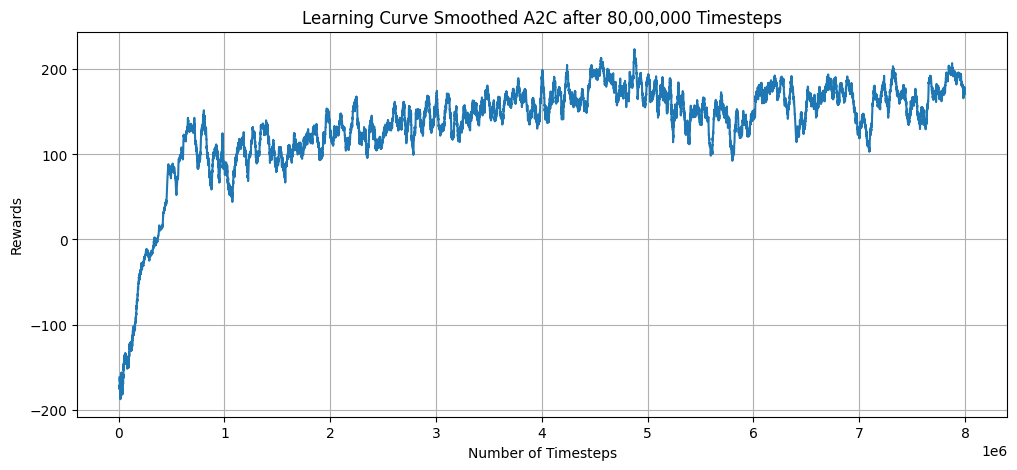

In [7]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """

    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]
    fig = plt.figure(title, figsize=(12,5))
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed A2C after 80,00,000 Timesteps")
    plt.grid()
    plt.show()

plot_results("log_dir_A2C_8")

# Evaluation 

In [8]:
env = make_vec_env("LunarLander-v2", n_envs=1,monitor_dir="log_dir_A2C_8")

In [9]:
model = A2C.load(path="log_dir_A2C_8/best_model.zip")

#### Stable Baseline 3 Evaluation Function. 

In [10]:
mean_reward, std_reward = evaluate_policy(model, env,n_eval_episodes=10, render=True, deterministic=True)
print("Mean & Std Reward after {} max run is {} & {}".format(10,mean_reward, std_reward)) 

Mean & Std Reward after 100 max run is 263.24761090000004 & 16.51837880754401


# GIF of a Train Agent

In [11]:
env = make_vec_env("LunarLander-v2", n_envs=1)
model = A2C.load(path="log_dir_A2C_8/best_model.zip")

images = []
obs = env.reset()
img = env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = env.step(action)
    img = env.render(mode="rgb_array")

imageio.mimsave("lunar lander_A2C_8.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
